# Modélisation – Prédiction de l'attrition

## 1. Contexte & objectifs

Ce notebook constitue la phase de modélisation du projet de prédiction de l'attrition. À partir des données nettoyées et enrichies lors de l'analyse exploratoire (1_notebook), l'objectif est de construire un modèle de classification binaire capable d'identifier les employés à risque de départ, afin de permettre aux équipes RH de mettre en place des actions préventives.

**Déséquilibre des classes** : seuls ~16 % des employés quittent l'entreprise, ce qui impose une stratégie de modélisation adaptée.

**Asymétrie des coûts** : un départ non détecté (faux négatif) coûte significativement plus cher qu'une fausse alerte (faux positif), qui se traduit par un simple entretien préventif.

**Stratégie** : nous procéderons par étapes — modèles baseline, gestion du déséquilibre, optimisation, puis interprétation

### Setup du notebook et chargement des données

In [1]:
import pandas as pd
import preprocessing as pp
import modelization as md
import visualizer as vi
import matplotlib.pyplot as plt

#Selection
from sklearn.model_selection import (
	train_test_split,
	StratifiedKFold
)
#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline compatible imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve


from sklearn.metrics import (
	make_scorer, recall_score, precision_score, f1_score,
	classification_report, confusion_matrix, average_precision_score
)

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

df = pd.read_csv("data/data_clean.csv")

TARGET = 'a_quitte_l_entreprise'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLIT = 5
CLASS_NAMES = ['Reste', 'Quitte']

X, y, preprocessor = pp.prepare_ml_data(
    df,
    target=TARGET,
    binary_ordinal_features=[
        'genre',
        'frequence_deplacement',
        'flag_surcharge_et_deplacement',
        'surcharge_travail',
        'note_evaluation_actuelle',
    ]
)

## 2. Préparation des données

### Inspection des données d'entrée

Avant de modéliser, vérifions la structure des données préparées lors de l'analyse exploratoire : dimensions de X et y, types de features détectés par le preprocessor, et aperçu des premières lignes.


In [2]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'str']).columns.tolist()

print(f"Dimensions : X = {X.shape}, y = {y.shape}")
print(f"\nFeatures numériques ({len(numeric_features)}) : {numeric_features}")
print(f"\nFeatures catégorielles ({len(categorical_features)}) : {categorical_features}")
print(f"\nDistribution de la cible :")
print(y.value_counts().rename(index={0: 'Reste', 1: 'Quitte'}))

display(X.head())

Dimensions : X = (1470, 28), y = (1470,)

Features numériques (25) : ['age', 'genre', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'frequence_deplacement', 'stabilite_management', 'surcharge_travail', 'flag_surcharge_et_deplacement', 'ratio_promotion_anciennete', 'satisfaction_globale', 'satisfaction_min', 'log_revenu']

Features catégorielles (3) : ['statut_marital', 'poste', 'domaine_etude']

Distribution de la cible :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64


,age,genre,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,augmentation_salaire_precedente,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,stabilite_management,surcharge_travail,flag_surcharge_et_deplacement,ratio_promotion_anciennete,satisfaction_globale,satisfaction_min,log_revenu
0,41,0,Célibataire,Cadre Commercial,8,8,6,4,2,3,4,1,1,3,11,0,0,1,2,Infra & Cloud,1,1.000000,2,0,0.000000,8,1,8.698514
1,49,1,Marié(e),Assistant de Direction,1,10,10,7,3,2,2,4,3,4,23,1,3,8,1,Infra & Cloud,2,0.875000,0,0,0.090909,12,2,8.543056
2,37,1,Célibataire,Consultant,6,7,0,0,4,2,3,2,3,3,15,0,3,2,2,Autre,1,0.000000,2,0,0.000000,12,2,7.645398
3,33,0,Marié(e),Assistant de Direction,1,8,8,7,4,3,3,3,3,3,11,0,3,3,4,Infra & Cloud,2,0.000000,3,1,0.333333,13,3,7.975908
4,27,1,Marié(e),Consultant,9,6,2,2,1,3,2,4,3,3,12,1,3,2,1,Transformation Digitale,1,0.666667,0,0,0.666667,10,1,8.151622


### Séparation train/test

Le découpage train/test est réalisé avec l’option `stratify=y` afin de préserver la distribution des classes dans les deux ensembles, ce qui est essentiel compte tenu du fort déséquilibre du jeu de données, et permet d’obtenir une évaluation plus représentative des performances du modèle.

Nous réservons 20% des données comme jeu de test pour l'évaluation finale des modèles, et nous appliquerons une validation croisée sur le jeu de train.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
	stratify=y
)

### Distribution des classes

Avant d'entraîner nos modèles, quantifions le déséquilibre entre les classes. Ce ratio conditionne directement la stratégie de modélisation et le choix des métriques, car un modèle naïf pourrait obtenir une accuracy élevée en prédisant systématiquement la classe majoritaire

Distribution globale :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64

Proportion :
a_quitte_l_entreprise
Reste     83.9%
Quitte    16.1%
Name: proportion, dtype: str

Ratio déséquilibre : 1 Quitte pour 5.2 Reste


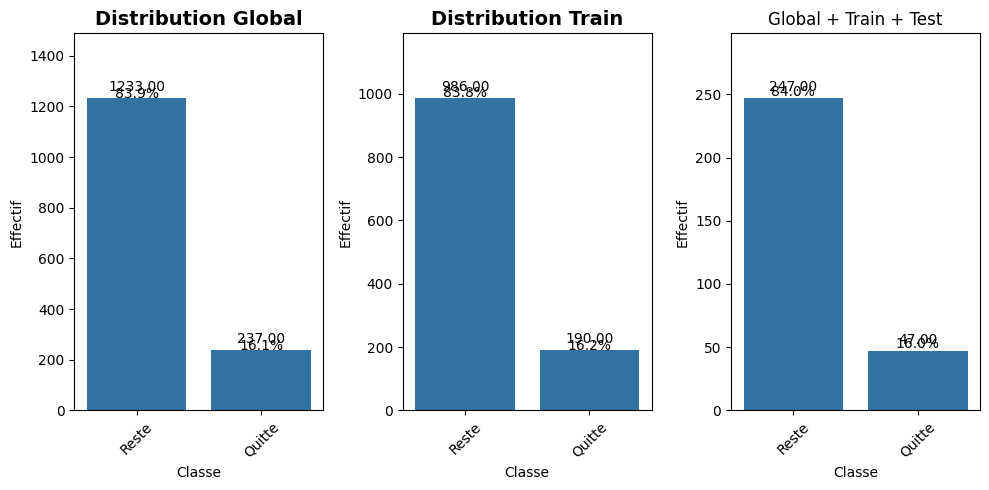

In [4]:
class_labels = {0: 'Reste', 1: 'Quitte'}

print("Distribution globale :")
print(y.value_counts().rename(index=class_labels))
print(f"\nProportion :")
print(y.value_counts(normalize=True).rename(index=class_labels).map(lambda x: f"{x:.1%}"))
print(f"\nRatio déséquilibre : 1 Quitte pour {y.value_counts()[0] / y.value_counts()[1]:.1f} Reste")

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for ax, (data, title) in zip(axes, [
    (y, "Global"), (y_train, "Train"), (y_test, "Test")
]):
    counts = data.value_counts().rename(index=class_labels)
    df_counts = pd.DataFrame({'Classe': counts.index, 'Effectif': counts.values})
    vi.create_barplot(
        df_counts, ax, x='Classe', y='Effectif',
        title=f'Distribution {title}'
    )
    for i, (label, count) in enumerate(counts.items()):
        pct = count / len(data)
        ax.text(i, count + 2, f"{pct:.1%}", ha='center', fontsize=10)
        
plt.title("Global + Train + Test")
plt.tight_layout()
plt.show()

**Observation**

La distribution montre un fort déséquilibre entre les classes : 83,9% des employés restent dans l’entreprise contre seulement 16,1% qui la quittent (environ 1 départ pour 5 employés restants).



## 3. Modèles baseline

### Choix des modèles

L’objectif est de prédire si un employé va quitter l’entreprise : il s’agit donc d’un problème de **classification binaire**.

Pour comparer différentes approches, quatre modèles ont été évalués :

- **DummyClassifier**  
  Sert de baseline avec la stratégie `most_frequent`, qui prédit systématiquement la classe majoritaire.  
  Cela permet d’établir un niveau minimal de performance et de vérifier que les modèles entraînés apportent un réel gain.

- **LogisticRegression**  
  Modèle linéaire simple, rapide et interprétable, utilisé comme première approche supervisée.

- **RandomForestClassifier**  
  Modèle non linéaire basé sur un ensemble d’arbres de décision, capable de capturer des relations complexes entre les variables.

- **XGBClassifier**  
  Modèle de gradient boosting qui entraîne les arbres séquentiellement, chaque nouvel arbre corrigeant les erreurs du précédent.

In [5]:
pipelines = {
    "Dummy": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', DummyClassifier(strategy="most_frequent"))
    ]),
	"LR_baseline": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_baseline": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "XGB_baseline": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
}

### Choix de la métrique principale

#### 1. Contexte du problème

Le projet vise à prédire le départ potentiel des employés (**attrition**), un problème de classification binaire caractérisé par un **déséquilibre marqué des classes**, la majorité des employés restant dans l’entreprise.

Dans ce contexte, l’évaluation des modèles ne peut pas se limiter à une métrique unique et doit intégrer à la fois la performance statistique et l’impact métier.


#### 2. Métriques évaluées

Plusieurs métriques sont utilisées afin d’analyser les performances des modèles sous différents angles :

- **Accuracy**  
  Proportion totale de prédictions correctes.  
  → Peu informative en cas de déséquilibre des classes, car elle favorise mécaniquement la classe majoritaire.

- **Precision (classe "Quitte")**  
  Proportion d’employés effectivement partis parmi ceux prédits comme partants.  
  → Mesure la fiabilité des alertes générées par le modèle.

- **Recall (classe "Quitte")**  
  Proportion d’employés ayant quitté l’entreprise correctement identifiés.  
  → Mesure la capacité du modèle à détecter les départs.

- **F1-score (classe "Quitte")**  
  Moyenne harmonique entre precision et recall.  
  → Permet d’évaluer le compromis entre détection des départs et limitation des fausses alertes.

- **ROC-AUC**  
  Mesure la capacité du modèle à classer un employé quittant l’entreprise avec un score de risque plus élevé qu’un employé restant, indépendamment du seuil de décision.  
  → Utilisée pour comparer le pouvoir de discrimination global des modèles.

- **PR-AUC (Area Under the Precision–Recall Curve)**  
  Synthétise le compromis précision/rappel sur la classe minoritaire.  
  → Particulièrement adaptée aux jeux de données déséquilibrés et plus représentative de la performance réelle sur la classe "Quitte".

Dans les résultats présentés, la precision, le recall et le F1-score sont calculés exclusivement sur la classe **"Quitte"** (classe positive = 1).


#### 3. Justification métier

L’objectif principal du modèle est d’**identifier le plus grand nombre possible d’employés susceptibles de quitter l’entreprise**, afin de permettre aux équipes RH de mettre en place des actions préventives (entretiens, mobilité interne, revalorisation).

##### Limites de l’accuracy

Un modèle prédisant systématiquement la classe majoritaire ("Reste") pourrait obtenir une accuracy élevée tout en étant inutilisable opérationnellement, car il ne détecterait aucun départ.

##### Priorité au recall sur la classe "Quitte"

Les coûts associés aux erreurs de classification sont asymétriques :

- **Faux négatif (départ non détecté)**  
  → Perte non anticipée, coûts élevés (recrutement, formation, perte de compétences)

- **Faux positif (fausse alerte)**  
  → Coût limité (entretien ou action RH préventive)

Cette asymétrie justifie de privilégier le **recall** sur la classe "Quitte".

##### Rôle du F1-score et de la PR-AUC

Optimiser uniquement le recall conduirait à générer un volume excessif de fausses alertes.  
Le F1-score et la PR-AUC permettent de vérifier que le modèle maintient un équilibre acceptable entre capacité de détection et précision des alertes.


#### 4. Métrique principale retenue et stratégie d’évaluation

La **ROC-AUC** est retenue comme métrique principale lors de la phase de sélection des modèles, car elle permet de comparer objectivement leur pouvoir discriminant indépendamment du seuil de décision.

La **PR-AUC** est utilisée comme métrique secondaire afin d’évaluer plus finement la performance sur la classe minoritaire dans un contexte de déséquilibre.

Enfin, le **recall sur la classe "Quitte"** est suivi comme indicateur clé de performance opérationnelle.  
Le seuil de décision est ajusté a posteriori afin de maximiser ce recall tout en maintenant un niveau de précision acceptable, en cohérence avec l’asymétrie des coûts métier identifiée précédemment.


In [6]:
cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
}

all_cv_results_baseline, all_eval_results_baseline, df_all_results_baseline = md.run_evaluation(
    pipelines, X_train, y_train, X_test, y_test, cv, scoring
)
display(df_all_results_baseline.round(2))

,cv_train_roc_auc,cv_train_roc_auc_std,cv_test_roc_auc,cv_test_roc_auc_std,cv_train_average_precision,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,cv_test_f1,cv_test_f1_std,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,,,,,,,
Dummy,0.50,0.00,0.50,0.00,0.16,0.00,0.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.04,0.84,0.00,0.00,0.00,0.16,0.50
LR_baseline,0.88,0.01,0.84,0.03,0.72,0.01,0.67,0.05,0.49,0.02,0.43,0.10,0.61,0.02,0.54,0.10,0.82,0.03,0.75,0.09,1.60,0.86,0.63,0.36,0.46,0.59,0.83
RF_baseline,1.00,0.00,0.82,0.04,1.00,0.00,0.57,0.06,1.00,0.00,0.19,0.08,1.00,0.00,0.30,0.10,1.00,0.00,0.84,0.11,1.65,0.84,0.50,0.15,0.23,0.43,0.79
XGB_baseline,1.00,0.00,0.81,0.04,1.00,0.00,0.58,0.04,1.00,0.00,0.34,0.06,1.00,0.00,0.45,0.06,1.00,0.00,0.67,0.07,0.73,0.86,0.61,0.30,0.40,0.49,0.80


**Observation**

Le modèle Dummy confirme l’absence totale de pouvoir prédictif (ROC AUC = 0.50, recall = 0), servant uniquement de référence minimale.

La LogisticRegression baseline montre les meilleures performances globales en généralisation parmi les modèles testés, avec un ROC AUC test de 0.83 et un PR AUC de 0.59. Elle détecte environ 36 % des départs réels sur le jeu de test (recall = 0.36), avec une précision correcte (0.63). Cela indique une capacité modérée à identifier les employés à risque, mais encore insuffisante compte tenu du coût élevé des faux négatifs.

Les modèles Random Forest et XGBoost présentent un surapprentissage marqué : leurs performances d’entraînement sont parfaites (ROC AUC = 1.00, recall = 1.00), mais chutent fortement en test. Le Random Forest atteint seulement 15 % de recall, tandis que XGBoost monte à 30 %, ce qui reste faible. Malgré des ROC AUC comparables à la régression logistique (~0.79–0.80), leur capacité réelle à détecter les départs est inférieure. 

D’un point de vue RH, LogisticRegression permet d’identifier environ un tiers des employés susceptibles de quitter l’entreprise, tandis que les modèles arbres ratent la majorité des départs. Les faux négatifs restent donc élevés pour tous les modèles, mais sont minimisés avec LogisticRegression. En pratique, cela signifie que sans ajustement supplémentaire (seuil ou rééquilibrage), une grande partie des collaborateurs à risque ne serait pas repérée, limitant l’efficacité des actions préventives

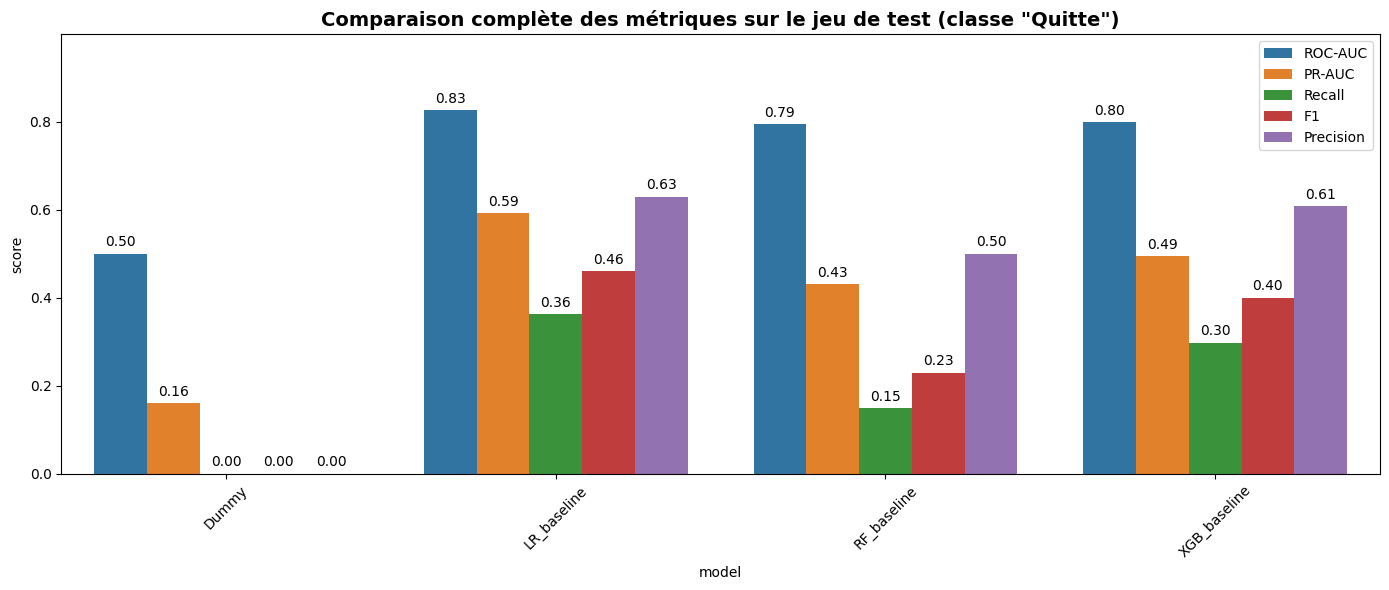

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))
vi.plot_metrics_comparison(
    df_all_results_baseline, ax,
    title='Comparaison complète des métriques sur le jeu de test (classe "Quitte")'
)
plt.tight_layout()
plt.show()


**Observation**

Le modèle Dummy confirme qu’un classement aléatoire ne permet pas d’identifier les départs (ROC AUC = 0.50, recall = 0), ce qui valide la nécessité d’un vrai modèle prédictif.

La régression logistique baseline présente le meilleur équilibre global sur le jeu de test : ROC AUC de 0.83, PR AUC de 0.59, recall de 0.36 et F1 de 0.46. C’est le modèle qui capte le plus grand nombre de départs réels tout en conservant une précision correcte (0.63).

XGBoost arrive en second avec un ROC AUC de 0.80 et un recall de 0.30, mais reste en dessous de la régression logistique sur tous les indicateurs clés liés à la détection des départs.

Le Random Forest affiche des performances plus faibles sur la classe “Quitte”, notamment un recall très bas (0.15) et un F1 à 0.23, ce qui signifie qu’il manque la grande majorité des employés quittant l’entreprise malgré une précision raisonnable (0.50).

Du point de vue RH, la régression logistique permet d’identifier environ 36 % des collaborateurs à risque, contre seulement 30 % pour XGBoost et 15 % pour Random Forest. Cela implique que, sans ajustement supplémentaire, entre 64 % et 85 % des départs potentiels passeraient inaperçus selon le modèle. Étant donné le coût élevé des faux négatifs, la régression logistique est actuellement l’option la plus pertinente parmi les baselines, car elle maximise la détection des départs tout en maintenant un volume de faux positifs maîtrisable.


**La courbe précision–rappel** permet de visualiser le compromis entre le nombre de départs détectés et le nombre de fausses alertes, en fonction du seuil de décision. Elle est particulièrement adaptée aux problèmes déséquilibrés comme l’attrition, car elle met l’accent sur la classe minoritaire.

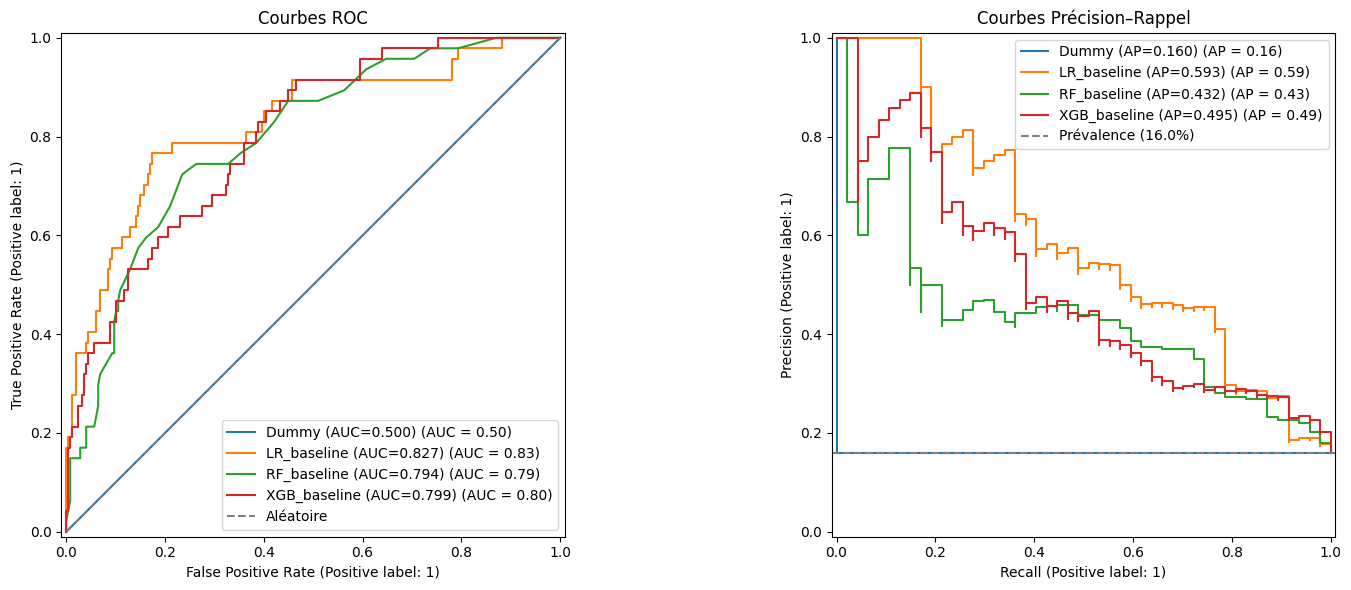

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

vi.create_roc_curves(all_eval_results_baseline, y_test, axes[0])
vi.create_pr_curves(all_eval_results_baseline, y_test, axes[1])

plt.tight_layout()
plt.show()

**Observation**

Les courbes ROC montrent que la régression logistique baseline est le modèle le plus discriminant (AUC ≈ 0.83), suivie de XGBoost et Random Forest (AUC ≈ 0.79–0.80). Les trois modèles sont nettement au-dessus de la diagonale aléatoire, ce qui confirme qu’ils apprennent un signal réel, mais la régression logistique garde un avantage constant sur presque toute la plage de seuils.

Sur les courbes précision–rappel, la différence entre modèles est plus marquée. La régression logistique obtient la meilleure aire sous la courbe (AP ≈ 0.59), largement au-dessus de la prévalence de la classe “Quitte” (16 %), ce qui indique une capacité significative à enrichir la population cible en vrais départs. XGBoost arrive ensuite (AP ≈ 0.49), puis Random Forest (AP ≈ 0.43).

On observe que, pour des niveaux de rappel compris entre environ 0.3 et 0.6 (zone typique d’exploitation métier), la régression logistique maintient systématiquement une précision plus élevée que les autres modèles. À l’inverse, Random Forest voit sa précision chuter rapidement lorsque le rappel augmente, ce qui signifie qu’il génère beaucoup de faux positifs dès qu’on cherche à capter davantage de départs.

D’un point de vue RH, cela implique que la régression logistique permet non seulement d’identifier plus d’employés à risque, mais aussi de le faire avec un meilleur “rendement” : pour un même nombre de collaborateurs ciblés, elle détecte davantage de vrais départs. XGBoost représente un compromis intermédiaire, tandis que Random Forest est moins adapté car il oblige soit à accepter très peu de départs détectés, soit à mobiliser beaucoup de ressources RH sur des faux positifs.

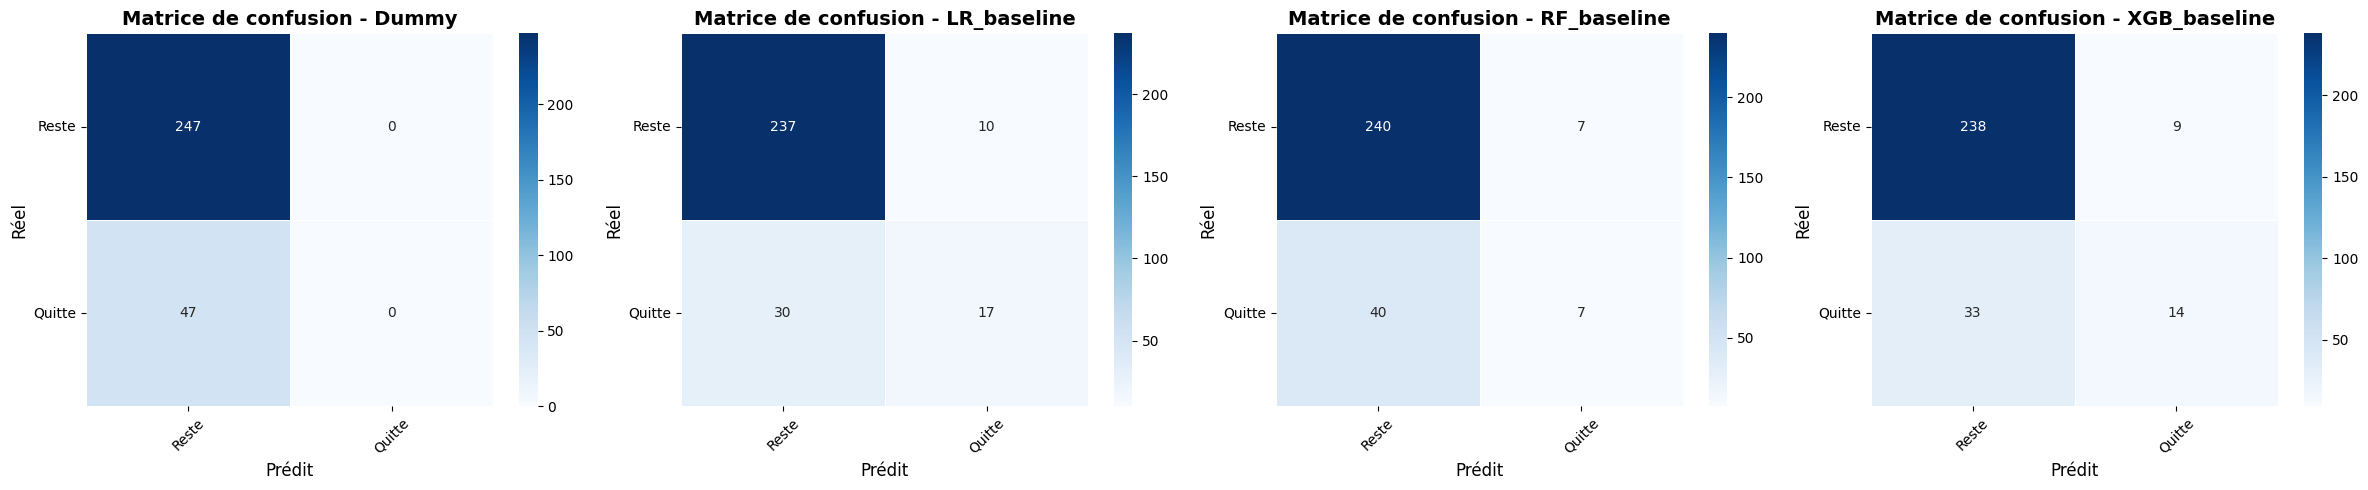

In [9]:
vi.plot_confusion_matrices(all_eval_results_baseline, CLASS_NAMES)

**Observation**

Le modèle Dummy prédit systématiquement “Reste” : aucun départ n’est détecté (47 faux négatifs, 0 vrais positifs). Cela confirme qu’un modèle naïf est totalement inutilisable dans un contexte RH orienté prévention.

La régression logistique baseline identifie 17 départs sur 47, mais en manque encore 30. Elle génère 10 faux positifs. Cela signifie qu’environ 36 % des départs sont correctement anticipés, au prix de quelques alertes injustifiées.

Le Random Forest ne détecte que 7 départs réels et en manque 40, ce qui correspond à une très faible capacité de détection (recall ≈ 15 %). Il produit peu de faux positifs (7), mais au prix d’un grand nombre de faux négatifs.

XGBoost détecte 14 départs et en manque 33, avec 9 faux positifs. Il se situe entre la régression logistique et le Random Forest, mais reste inférieur à la régression logistique en nombre de départs identifiés.

D’un point de vue RH, la régression logistique permet d’anticiper environ un tiers des départs potentiels (17 collaborateurs), contre seulement 14 pour XGBoost et 7 pour Random Forest. Concrètement, cela signifie qu’avec la régression logistique, les équipes RH peuvent intervenir de manière proactive auprès d’un plus grand nombre d’employés réellement à risque, tout en limitant raisonnablement le nombre de collaborateurs contactés à tort. À l’inverse, Random Forest minimise les faux positifs mais laisse partir la grande majorité des employés sans alerte préalable, ce qui est incompatible avec un objectif de prévention des départs.

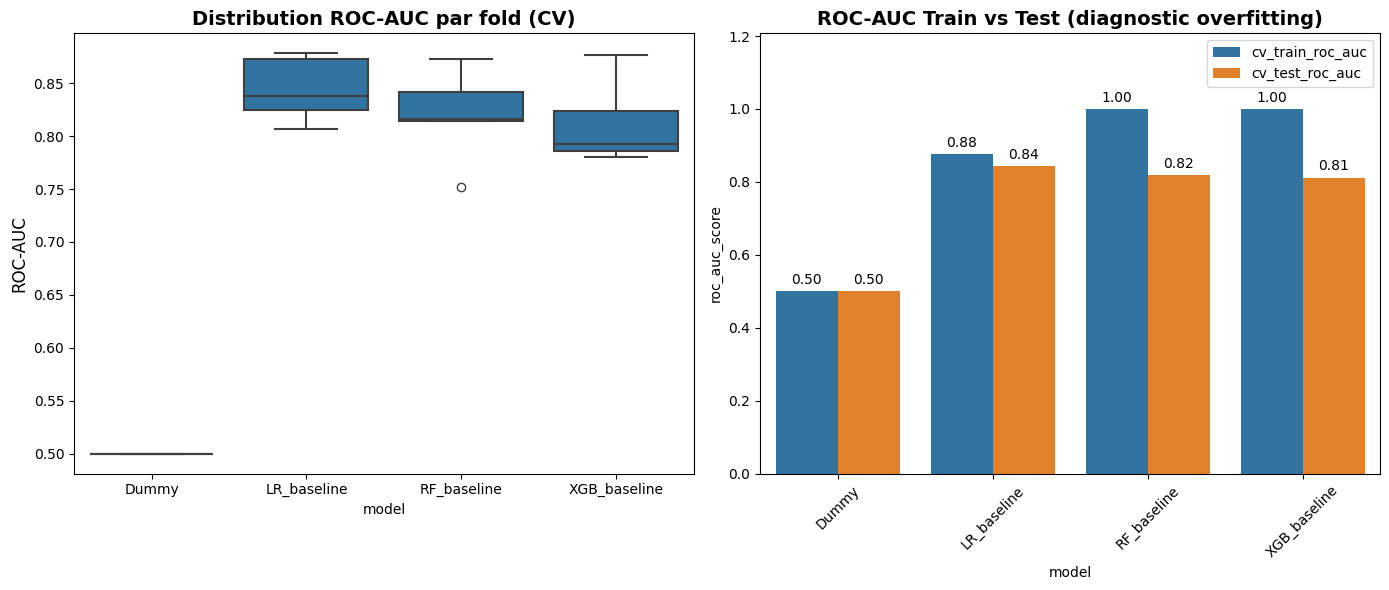

In [10]:
vi.visualize_cv_results(all_cv_results_baseline, df_all_results_baseline, metric='roc_auc')

**Observation**

La distribution du ROC-AUC en validation croisée montre que la régression logistique présente des performances stables entre les différents folds, avec une dispersion faible autour de 0.83–0.87. XGBoost affiche une variabilité légèrement plus marquée mais reste globalement cohérent. Random Forest présente une dispersion plus importante et un fold plus faible, suggérant une instabilité plus élevée selon les sous-échantillons.

Le graphique Train vs Test met en évidence un surapprentissage important pour Random Forest et XGBoost : leur ROC-AUC d’entraînement atteint 1.00 alors que le score test chute autour de 0.81–0.82. L’écart train-test est donc significatif. À l’inverse, la régression logistique montre un écart beaucoup plus faible (0.88 en train vs 0.84 en test), indiquant une meilleure capacité de généralisation.

D’un point de vue RH, cela signifie que les modèles arbres apprennent très bien les données historiques mais généralisent moins bien à de nouveaux employés. Ils risquent donc d’être moins fiables en production. La régression logistique apparaît plus robuste et plus stable, ce qui est essentiel dans un contexte RH où les décisions impactent directement les collaborateurs et les ressources internes.

### Conclusion — Modèles baseline

Les modèles baseline confirment qu'ignorer le déséquilibre des classes conduit à des performances métier insuffisantes.

Le Dummy ne détecte aucun départ. Random Forest et XGBoost privilégient 
la précision mais ratent la majorité des employés quittant l'entreprise.

La régression logistique est la meilleure option parmi ces approches, mais son recall reste trop faible pour un usage RH opérationnel : à ce stade, deux tiers des départs passent inaperçus.

Ce constat justifie le passage à une stratégie intégrant explicitement le déséquilibre des classes.

## 4. Gestion du déséquilibre

### 4.1 Pondération des classes (class_weight)

- `class_weight='balanced'` ajuste automatiquement les poids des 
  classes afin de compenser leur déséquilibre.

- `scale_pos_weight` (équivalent XGBoost) augmente le poids de la 
  classe minoritaire (*Quitte*) dans la fonction de perte.
  Il est calculé comme : **n_reste / n_quitte**.

In [11]:
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

pipelines_balanced = {
	"LR_balanced": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_balanced": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
    ]),
    "XGB_balanced": Pipeline([
        ('preprocessor', clone(preprocessor)),
        ('model', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE))
    ])
}

all_cv_results_balanced, all_eval_results_balanced, df_all_results_balanced = md.run_evaluation(
    pipelines_balanced, X_train, y_train, X_test, y_test, cv, scoring
)
display(df_all_results_balanced.round(2))

,cv_train_roc_auc,cv_train_roc_auc_std,cv_test_roc_auc,cv_test_roc_auc_std,cv_train_average_precision,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,cv_test_f1,cv_test_f1_std,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,,,,,,,
LR_balanced,0.88,0.01,0.84,0.03,0.69,0.01,0.64,0.06,0.81,0.01,0.73,0.09,0.56,0.01,0.50,0.03,0.43,0.01,0.38,0.01,0.12,0.81,0.44,0.72,0.54,0.58,0.83
RF_balanced,1.00,0.00,0.81,0.04,1.00,0.00,0.56,0.06,1.00,0.00,0.18,0.07,1.00,0.00,0.29,0.09,1.00,0.00,0.88,0.11,0.46,0.84,0.46,0.13,0.20,0.42,0.78
XGB_balanced,1.00,0.00,0.80,0.04,1.00,0.00,0.59,0.06,1.00,0.00,0.42,0.06,1.00,0.00,0.50,0.06,1.00,0.00,0.64,0.07,0.45,0.85,0.54,0.40,0.46,0.47,0.77


**Observation**

La régression logistique équilibrée montre une amélioration très nette du rappel, qui passe à 0.72 sur le jeu de test, contre 0.36 en baseline. Cela signifie que près de trois quarts des départs sont désormais détectés. Cette hausse du recall s’accompagne d’une baisse de la précision (0.44) et d’une légère baisse de l’accuracy, ce qui est attendu dans un contexte de rééquilibrage. Le ROC AUC reste stable (0.83) et le PR AUC progresse légèrement (0.58 vs 0.59 baseline), indiquant que le pouvoir discriminant global est conservé.

Random Forest équilibré conserve un fort surapprentissage (scores parfaits en entraînement) et reste très faible en détection des départs (recall test = 0.13). Le rééquilibrage n’apporte donc pas d’amélioration significative pour ce modèle.

XGBoost équilibré améliore son recall par rapport au baseline (0.40 contre 0.30), mais reste loin derrière la régression logistique équilibrée. Il présente également un surapprentissage marqué et un ROC AUC test plus faible (0.77).

Du point de vue RH, la régression logistique équilibrée transforme fortement l’usage du modèle : au lieu d’identifier seulement un tiers des départs, elle permet désormais d’anticiper environ 70 % des collaborateurs susceptibles de quitter l’entreprise. Cela augmente le nombre de faux positifs, mais offre aux équipes RH une capacité beaucoup plus large d’intervention préventive. Les modèles arbres restent peu fiables pour cet objectif, car ils continuent à manquer la majorité des départs malgré le rééquilibrage.


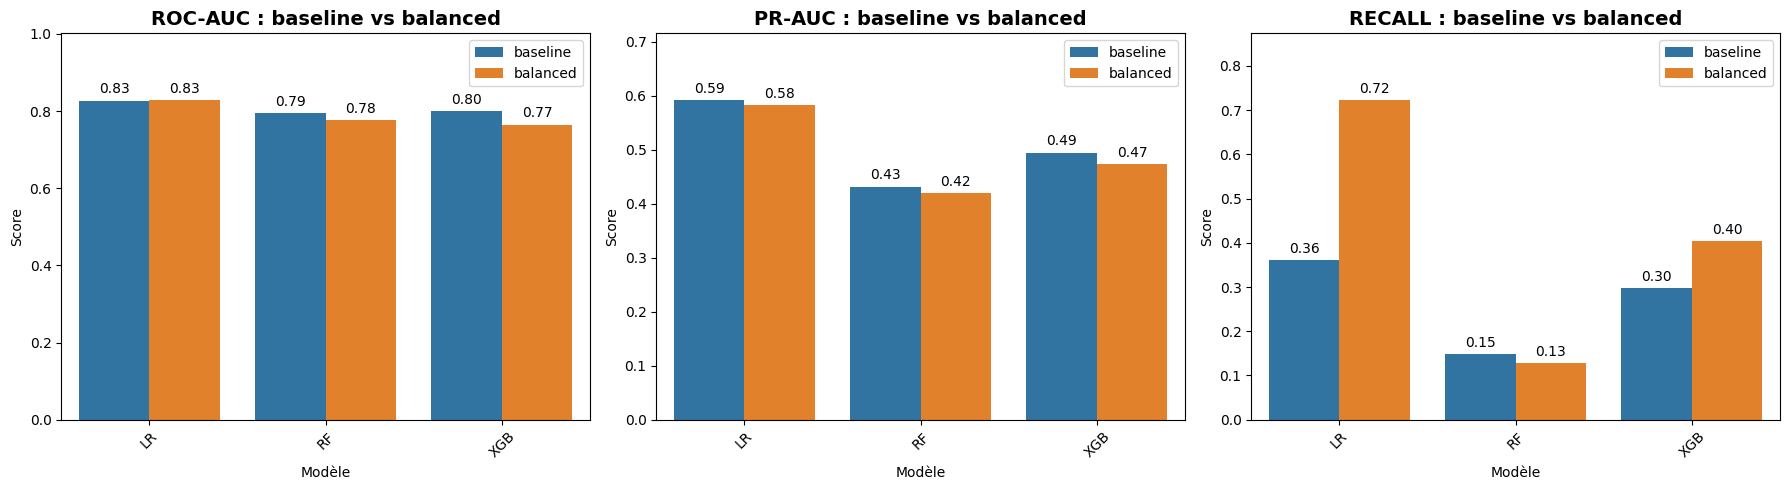

In [12]:
vi.compare_model_versions(
    results={'baseline': df_all_results_baseline, 'balanced': df_all_results_balanced},
    models=['LR', 'RF', 'XGB'],
)

**Observation**

Le rééquilibrage des classes n’impacte quasiment pas le ROC AUC pour la régression logistique (0.83 dans les deux cas), ce qui montre que le pouvoir discriminant global du modèle reste stable. En revanche, on observe une légère baisse du ROC AUC pour Random Forest et XGBoost après équilibrage.

Le PR AUC diminue très légèrement pour l’ensemble des modèles, ce qui indique que le rééquilibrage ne crée pas de gain sur la qualité globale du ranking, mais modifie surtout la distribution des prédictions.

L’effet majeur du rééquilibrage apparaît sur le recall. Pour la régression logistique, le rappel double quasiment, passant de 0.36 à 0.72. Cela signifie que le modèle équilibré détecte environ deux fois plus de départs qu’en baseline. XGBoost bénéficie d’une amélioration plus modérée (0.30 → 0.40), tandis que Random Forest reste très faible (0.15 → 0.13).

D’un point de vue RH, la régression logistique équilibrée change radicalement l’utilité opérationnelle du modèle : elle permet désormais d’identifier la majorité des employés susceptibles de quitter l’entreprise, sans dégrader la capacité globale de discrimination. Les modèles arbres, en revanche, profitent peu du rééquilibrage et continuent à manquer la majorité des départs. Cela confirme que la régression logistique est la base la plus adaptée pour un objectif de prévention, où la priorité est de réduire les faux négatifs.


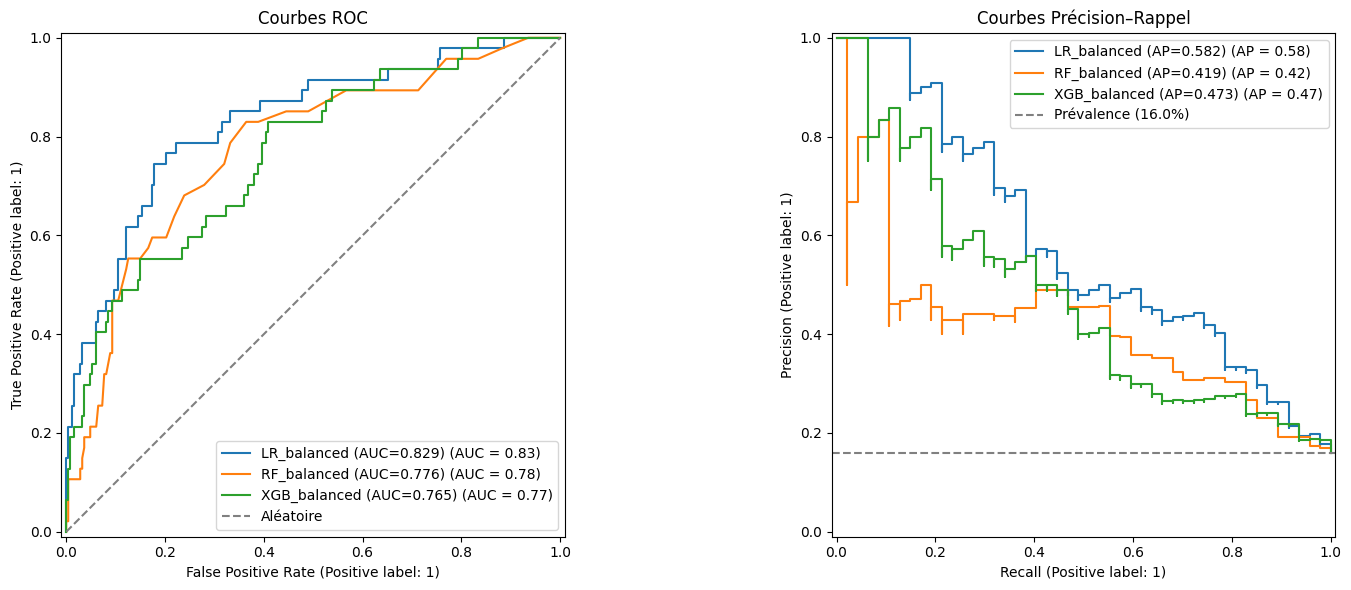

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

vi.create_roc_curves(all_eval_results_balanced, y_test, axes[0])
vi.create_pr_curves(all_eval_results_balanced, y_test, axes[1])

plt.tight_layout()
plt.show()

**Observation**

Les courbes ROC des modèles équilibrés confirment que la régression logistique conserve la meilleure capacité de discrimination (AUC ≈ 0.83), avec une courbe systématiquement au-dessus de celles de Random Forest et XGBoost. Le rééquilibrage n’a donc pas dégradé la qualité globale du classement des individus.

Sur les courbes précision–rappel, la régression logistique équilibrée présente également la meilleure aire sous la courbe (AP ≈ 0.58), nettement au-dessus de la prévalence de la classe (16 %). Elle maintient une précision plus élevée que les autres modèles pour des niveaux de rappel compris entre 0.3 et 0.7, zone correspondant à un usage réaliste en contexte métier. Random Forest affiche la performance la plus faible (AP ≈ 0.42), tandis que XGBoost reste intermédiaire (AP ≈ 0.47).

D’un point de vue RH, cela signifie que la régression logistique équilibrée permet de détecter une large part des départs tout en conservant un niveau de précision acceptable. Pour un même volume d’employés ciblés, elle identifie davantage de vrais départs que les autres modèles. Elle apparaît donc comme la solution la plus robuste et la plus pertinente pour un objectif de prévention, où la priorité est de maximiser la détection des collaborateurs à risque sans mobiliser excessivement les ressources RH.


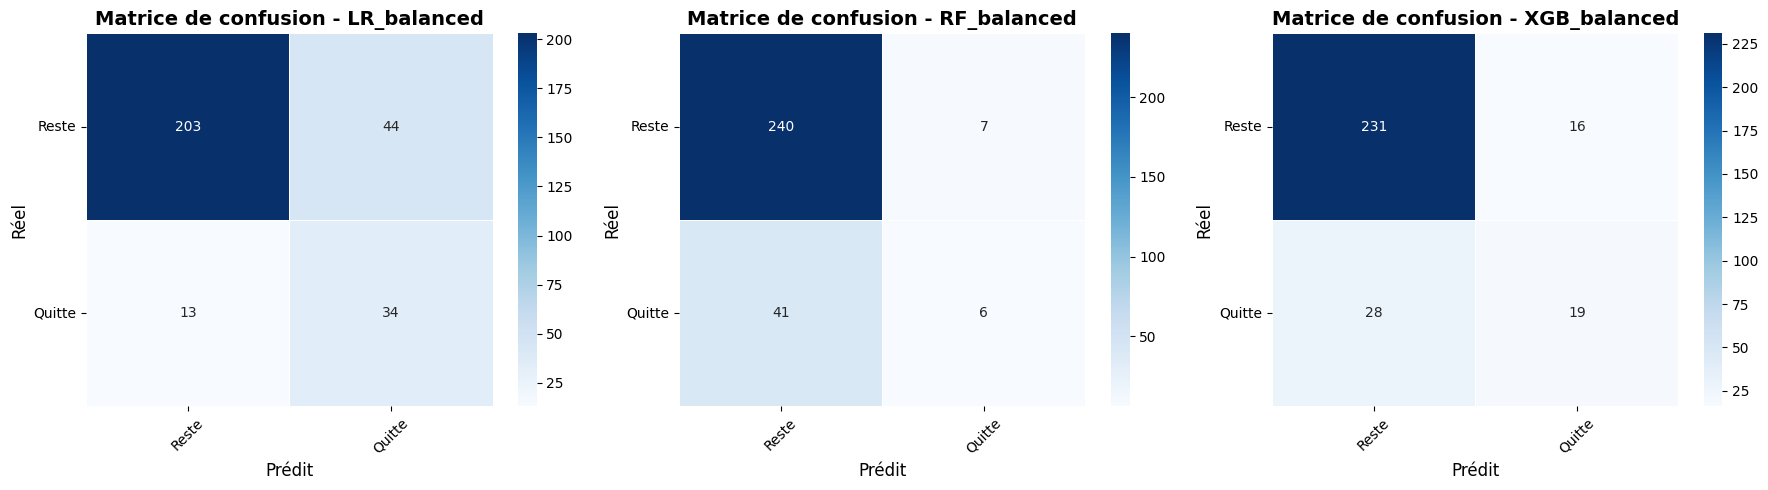

In [14]:
vi.plot_confusion_matrices(all_eval_results_balanced, CLASS_NAMES)

**Observation**

La régression logistique équilibrée détecte désormais 34 départs sur 47, contre seulement 17 en baseline. Le nombre de faux négatifs chute fortement (13 au lieu de 30), ce qui montre un gain majeur en capacité de détection. En contrepartie, le nombre de faux positifs augmente (44 collaborateurs signalés à tort), ce qui est cohérent avec l’objectif de maximiser le rappel.

Le Random Forest équilibré ne détecte que 6 départs et en manque encore 41. Le rééquilibrage n’améliore donc pas sa performance métier, le modèle restant très conservateur avec très peu de prédictions “Quitte”.

XGBoost équilibré identifie 19 départs et en manque 28, ce qui représente une amélioration par rapport au baseline, mais reste nettement inférieur à la régression logistique équilibrée. Il génère également moins de faux positifs que la régression logistique, mais au prix d’un nombre plus élevé de départs non anticipés.

D’un point de vue RH, la régression logistique équilibrée permet d’anticiper près de 3 départs sur 4, ce qui change radicalement la capacité d’action des équipes RH : la majorité des collaborateurs à risque peut désormais être identifiée à temps pour envisager des actions de rétention. Cela implique toutefois de mobiliser des ressources sur un volume plus important d’employés non concernés. Les modèles arbres restent moins adaptés à un objectif de prévention, car ils continuent à laisser partir trop de collaborateurs sans alerte préalable.


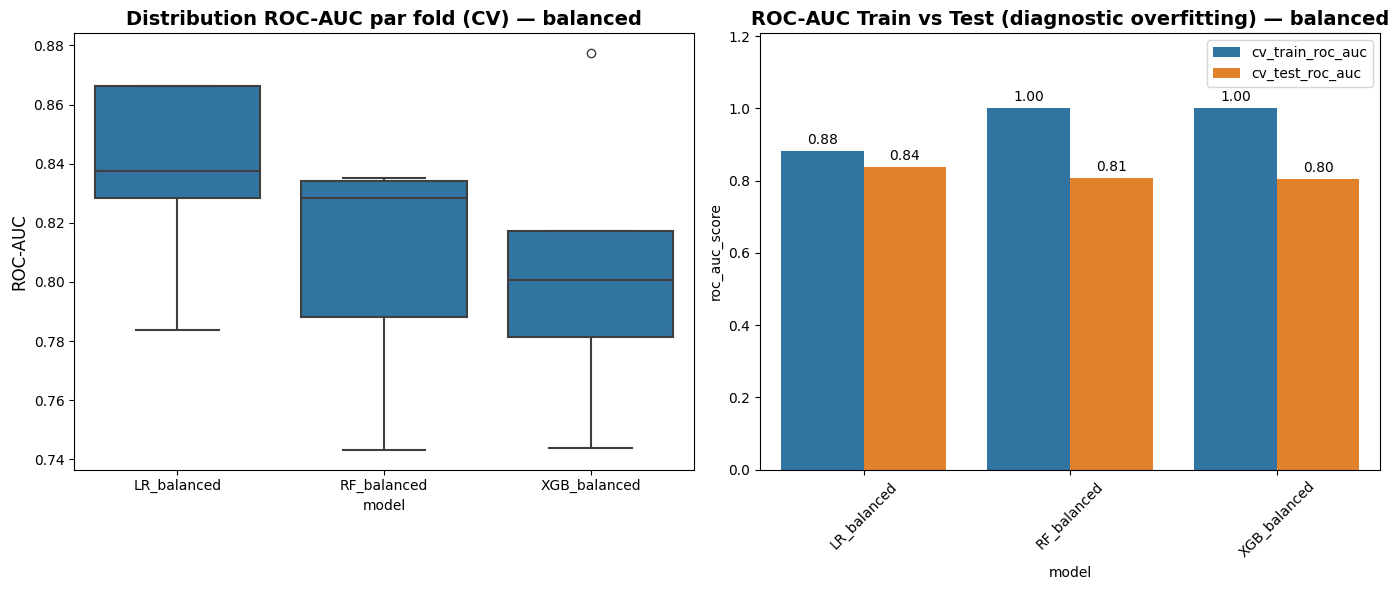

In [15]:
vi.visualize_cv_results(all_cv_results_balanced, df_all_results_balanced, metric='roc_auc', suffix='balanced')

**Observation**

La distribution du ROC-AUC en validation croisée montre que la régression logistique équilibrée reste la plus stable, avec des scores concentrés autour de 0.83–0.86 et une dispersion limitée. Random Forest et XGBoost présentent une variabilité plus importante selon les folds, ce qui indique une sensibilité plus forte aux sous-échantillons.

Le graphique Train vs Test met à nouveau en évidence un surapprentissage marqué pour Random Forest et XGBoost, avec un ROC-AUC d’entraînement à 1.00 alors que le score test chute autour de 0.80–0.81. La régression logistique équilibrée conserve un écart train–test réduit (0.88 vs 0.84), confirmant une meilleure capacité de généralisation.

D’un point de vue RH, cela signifie que la régression logistique équilibrée est non seulement le modèle qui détecte le plus de départs, mais aussi le plus fiable dans le temps. Les modèles arbres restent plus instables et risquent de produire des performances variables selon les périodes ou populations d’employés, ce qui est problématique pour un outil d’aide à la décision RH destiné à être utilisé en continu.


#### Conclusion — Section Balanced

La pondération des classes transforme significativement les résultats. La régression logistique passe d’un modèle détectant peu de départs à un modèle capable d’en identifier environ 70 %, ce qui répond beaucoup mieux aux enjeux RH liés au coût élevé des faux négatifs. Random Forest reste inefficace malgré la pondération, tandis que XGBoost progresse mais sans atteindre le niveau de LR_balanced.

À ce stade, LR_balanced devient le candidat principal avec un recall d’environ 70 %, contre 36 % en baseline, tout en conservant une bonne capacité de discrimination. Pour explorer un éventuel gain supplémentaire sur la détection des départs, nous testons ensuite une approche par sur-échantillonnage avec SMOTE.


### 4.2 SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE est une technique de sur-échantillonnage qui génère des exemples synthétiques de la classe minoritaire. Contrairement au simple oversampling qui duplique les observations existantes, SMOTE crée de nouveaux points en interpolant entre des voisins proches.

**Pourquoi tester SMOTE ?**
- `class_weight='balanced'` n'a pas fonctionné pour le Random Forest
- SMOTE peut aider les modèles à mieux apprendre les frontières de décision de la classe minoritaire

**Important** : SMOTE doit être appliqué uniquement sur le jeu d'entraînement (jamais sur le test) pour éviter la fuite de données.


In [16]:
smote = SMOTE(random_state=RANDOM_STATE)

pipelines_smote = {
    "LR_SMOTE": ImbPipeline([
        ('preprocessor', clone(preprocessor)),
        ('smote', smote),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RF_SMOTE": ImbPipeline([
        ('preprocessor', clone(preprocessor)),
        ('smote', smote),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ]),
    "XGB_SMOTE": ImbPipeline([
        ('preprocessor', clone(preprocessor)),
        ('smote', smote),
        ('model', XGBClassifier(random_state=RANDOM_STATE))
    ])
}

all_cv_results_smote, all_eval_results_smote, df_all_results_smote = md.run_evaluation(
    pipelines_smote, X_train, y_train, X_test, y_test, cv, scoring
)
display(df_all_results_smote.round(2))

,cv_train_roc_auc,cv_train_roc_auc_std,cv_test_roc_auc,cv_test_roc_auc_std,cv_train_average_precision,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,cv_test_f1,cv_test_f1_std,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,,,,,,,
LR_SMOTE,0.88,0.01,0.83,0.03,0.69,0.02,0.63,0.06,0.79,0.01,0.72,0.09,0.57,0.02,0.50,0.03,0.45,0.02,0.39,0.01,0.22,0.81,0.45,0.72,0.55,0.57,0.82
RF_SMOTE,1.00,0.00,0.82,0.04,1.00,0.00,0.58,0.08,1.00,0.00,0.31,0.10,1.00,0.00,0.44,0.11,1.00,0.00,0.78,0.11,0.67,0.85,0.59,0.21,0.31,0.43,0.78
XGB_SMOTE,1.00,0.00,0.80,0.03,1.00,0.00,0.56,0.04,1.00,0.00,0.38,0.06,1.00,0.00,0.47,0.05,1.00,0.00,0.62,0.03,0.57,0.86,0.59,0.34,0.43,0.51,0.79


**Observation**

Avec SMOTE, la régression logistique conserve des performances très proches de la version balanced : le recall atteint 0.72 (identique à LR_balanced), avec une précision légèrement meilleure (0.45 vs 0.44) et un F1 légèrement supérieur (0.55 vs 0.54). Le ROC AUC reste stable (0.82) et le PR AUC est comparable (0.57). Cela indique que SMOTE n’apporte pas de gain significatif par rapport à la simple pondération des classes pour ce modèle.

Random Forest avec SMOTE montre une amélioration du recall (0.31 contre 0.13 en balanced), mais reste très fortement sur-appris (scores parfaits en entraînement). Malgré un meilleur F1, il continue à manquer une grande partie des départs et présente une généralisation limitée.

XGBoost avec SMOTE progresse légèrement par rapport à XGB_balanced (recall = 0.34 contre 0.40 en balanced selon test direct, et F1 ≈ 0.43), mais conserve un surapprentissage marqué et des performances globales inférieures à la régression logistique.

D’un point de vue RH, SMOTE ne change pas fondamentalement la hiérarchie des modèles. La régression logistique reste la plus efficace pour détecter les départs (environ 72 %), avec un volume de faux positifs comparable à la version balanced. Les modèles arbres bénéficient partiellement de SMOTE mais restent moins fiables et plus instables. En pratique, SMOTE n’apporte pas d’avantage clair par rapport à la pondération des classes pour atteindre l’objectif principal de réduction des faux négatifs.


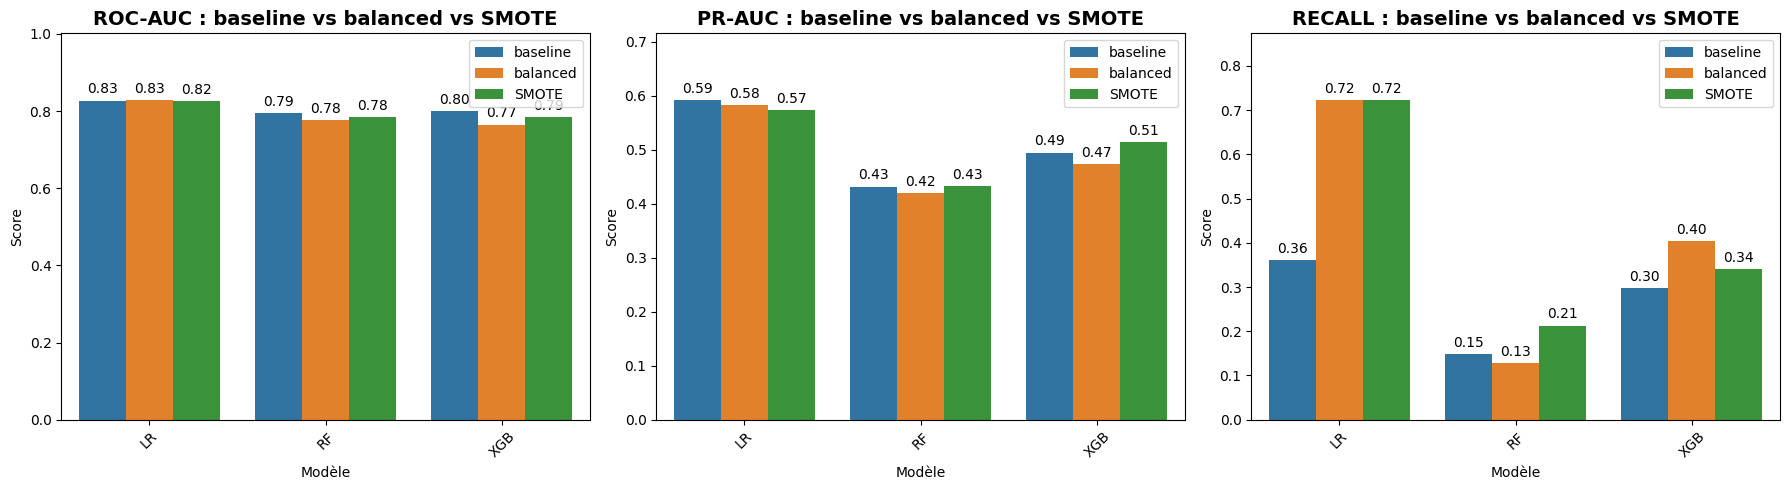

In [17]:
vi.compare_model_versions(
    results={'baseline': df_all_results_baseline, 'balanced': df_all_results_balanced, 'SMOTE': df_all_results_smote},
    models=['LR', 'RF', 'XGB'],
)

**Observation**

Le ROC AUC reste globalement stable pour l’ensemble des modèles, quelle que soit la méthode de gestion du déséquilibre. Pour la régression logistique, il reste autour de 0.83 dans les trois cas, ce qui montre que ni la pondération ni SMOTE ne modifient significativement la capacité de discrimination globale du modèle.

Le PR AUC évolue peu pour la régression logistique (0.59 → 0.58 → 0.57), confirmant que SMOTE n’apporte pas de gain notable par rapport à la pondération des classes. Pour Random Forest et XGBoost, les variations sont modestes, sans amélioration décisive.

La différence majeure apparaît sur le recall. Pour la régression logistique, baseline = 0.36, balanced = 0.72 et SMOTE = 0.72. Cela signifie que la pondération des classes suffit déjà à doubler la capacité de détection des départs, et que SMOTE n’apporte pas d’amélioration supplémentaire. Pour Random Forest, SMOTE améliore légèrement le recall par rapport à balanced, mais le niveau reste faible. Pour XGBoost, SMOTE n’apporte pas de gain par rapport à balanced et reste inférieur à la régression logistique.

D’un point de vue RH, la pondération des classes constitue le levier principal d’amélioration pour détecter les départs. SMOTE ne change pas significativement la performance du modèle le plus pertinent (régression logistique) et n’inverse pas la hiérarchie des modèles. Ainsi, la régression logistique avec pondération apparaît comme la solution la plus efficace et la plus simple à déployer pour maximiser la détection des collaborateurs à risque.


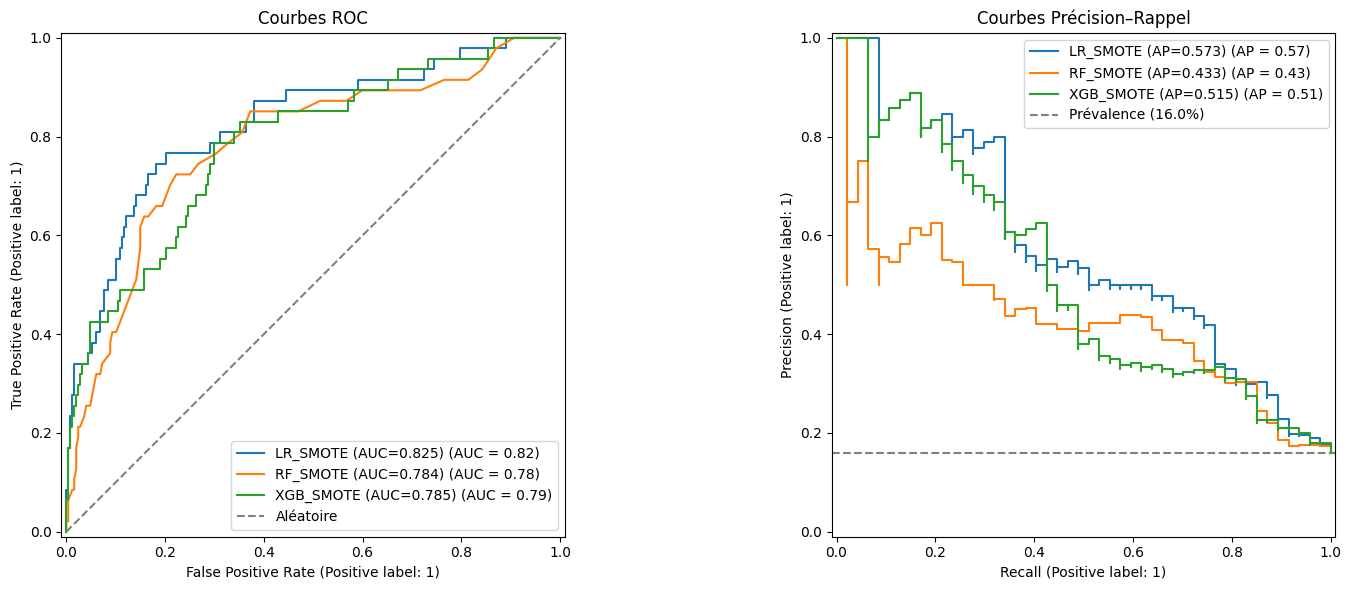

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

vi.create_roc_curves(all_eval_results_smote, y_test, axes[0])
vi.create_pr_curves(all_eval_results_smote, y_test, axes[1])

plt.tight_layout()
plt.show()

**Observation**

Les courbes ROC montrent que la régression logistique avec SMOTE conserve la meilleure capacité de discrimination (AUC ≈ 0.82), devant XGBoost (≈ 0.79) et Random Forest (≈ 0.78). Les écarts restent proches de ceux observés avec la pondération des classes, indiquant que SMOTE n’améliore pas le classement global des employés par risque de départ.

Sur les courbes précision–rappel, la régression logistique SMOTE obtient également la meilleure aire sous la courbe (AP ≈ 0.57), suivie de XGBoost (≈ 0.51) puis Random Forest (≈ 0.43). Toutefois, ces valeurs sont très proches de celles obtenues avec la méthode balanced. Pour des niveaux de rappel compris entre 0.4 et 0.7, la régression logistique conserve une précision supérieure, ce qui correspond à une zone d’exploitation réaliste en contexte RH.

D’un point de vue RH, SMOTE ne permet pas d’identifier davantage de départs que la pondération des classes pour la régression logistique, et n’améliore pas la qualité globale des alertes. Le modèle LR_SMOTE offre des performances similaires à LR_balanced, sans bénéfice clair supplémentaire, tandis que les modèles arbres restent moins efficaces et plus instables pou


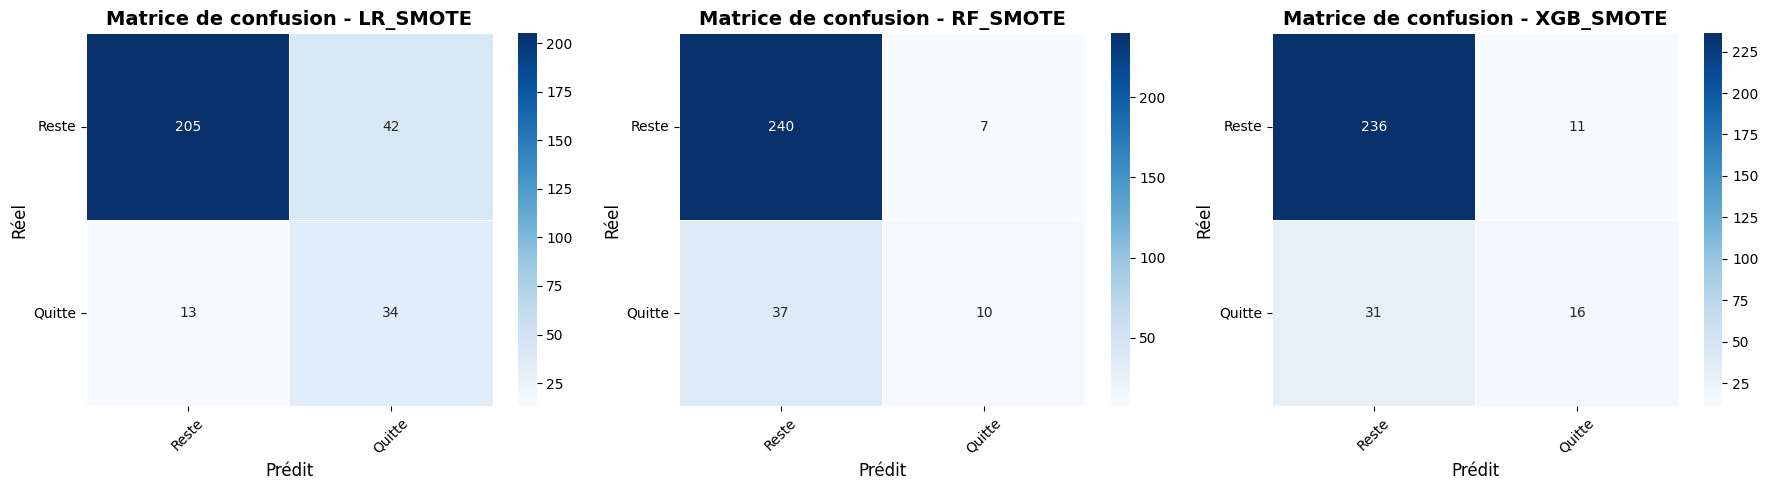

In [19]:
vi.plot_confusion_matrices(all_eval_results_smote, CLASS_NAMES)

**Observation**

La matrice de LR_SMOTE montre un nombre élevé de vrais positifs, mais comparable à LR_balanced. 

RF_SMOTE détecte davantage de départs qu’en baseline, mais laisse encore passer une large majorité. 

XGB_SMOTE progresse légèrement. 

Pour les RH, seule la régression logistique offre un niveau acceptable de détection, tandis que les modèles arbres restent insuffisants malgré SMOTE

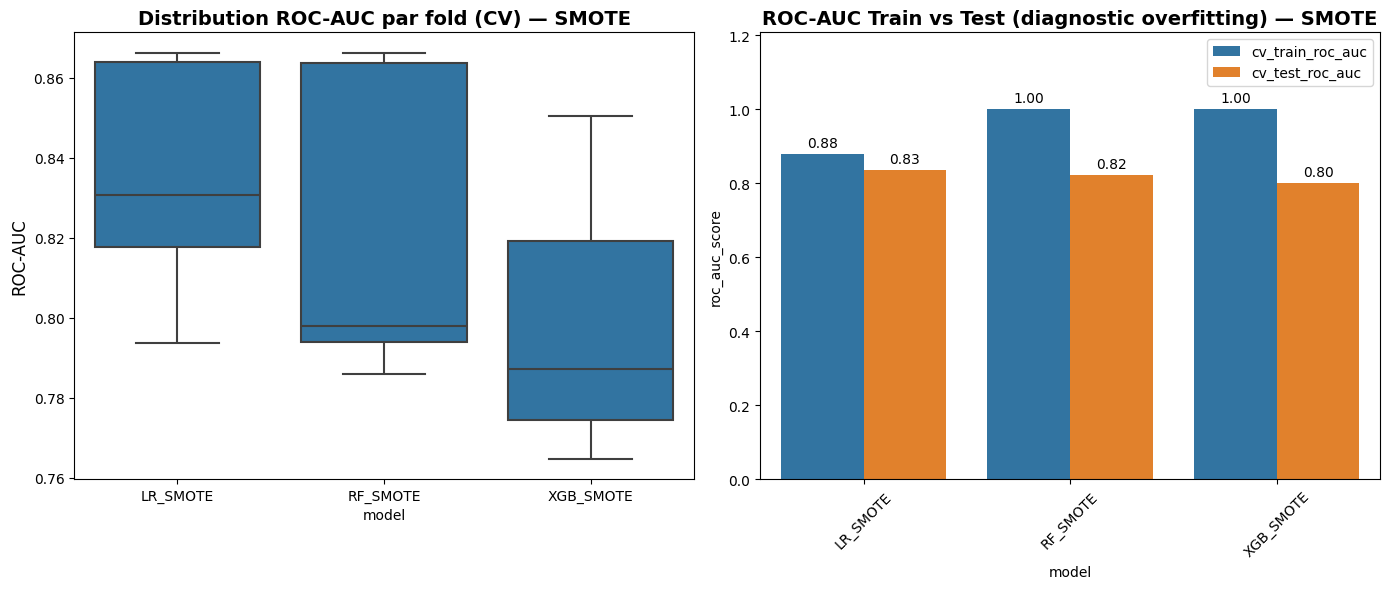

In [20]:
vi.visualize_cv_results(all_cv_results_smote, df_all_results_smote, metric='roc_auc', suffix='SMOTE')

**Observation**

La régression logistique avec SMOTE détecte 34 départs sur 47, soit exactement le même niveau que la version balanced. Le nombre de faux négatifs reste identique (13), tandis que les faux positifs sont légèrement inférieurs (42 contre 44). Cela confirme que SMOTE n’apporte pas de gain concret par rapport à la pondération des classes pour ce modèle.

Random Forest avec SMOTE détecte 10 départs et en manque 37. Bien que ce soit légèrement mieux que la version balanced, le modèle reste très en retrait par rapport à la régression logistique, avec une majorité de départs non anticipés.

XGBoost avec SMOTE identifie 16 départs et en manque 31, ce qui reste inférieur à LR_SMOTE. Il génère moins de faux positifs, mais au prix d’un nombre plus élevé de faux négatifs.

D’un point de vue RH, la régression logistique avec SMOTE permet d’anticiper environ 3 départs sur 4, mais sans amélioration par rapport à LR_balanced. SMOTE ne réduit pas davantage les faux négatifs, qui restent l’enjeu principal métier. Les modèles arbres continuent à laisser partir trop de collaborateurs sans alerte préalable. En pratique, SMOTE n’apporte pas de bénéfice opérationnel supplémentaire face à la pondération simple des classes.



,CV PR-AUC,Test PR-AUC,CV recall,Test recall,CV precision,Test precision,CV f1,Test f1
Modèle,,,,,,,,
Dummy,0.162 ± 0.000,0.160,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000
LR_baseline,0.665 ± 0.050,0.593,0.432 ± 0.098,0.362,0.748 ± 0.087,0.630,0.544 ± 0.097,0.459
RF_baseline,0.575 ± 0.061,0.432,0.195 ± 0.083,0.149,0.841 ± 0.108,0.500,0.302 ± 0.102,0.230
XGB_baseline,0.581 ± 0.039,0.495,0.342 ± 0.058,0.298,0.666 ± 0.074,0.609,0.448 ± 0.058,0.400
LR_balanced,0.638 ± 0.060,0.582,0.732 ± 0.087,0.723,0.384 ± 0.009,0.436,0.502 ± 0.025,0.544
RF_balanced,0.560 ± 0.056,0.419,0.184 ± 0.074,0.128,0.879 ± 0.111,0.462,0.294 ± 0.088,0.200
XGB_balanced,0.586 ± 0.056,0.473,0.416 ± 0.063,0.404,0.638 ± 0.070,0.543,0.500 ± 0.057,0.463
LR_SMOTE,0.626 ± 0.056,0.573,0.716 ± 0.087,0.723,0.391 ± 0.008,0.447,0.505 ± 0.027,0.553
RF_SMOTE,0.581 ± 0.085,0.433,0.311 ± 0.100,0.213,0.782 ± 0.106,0.588,0.435 ± 0.109,0.312


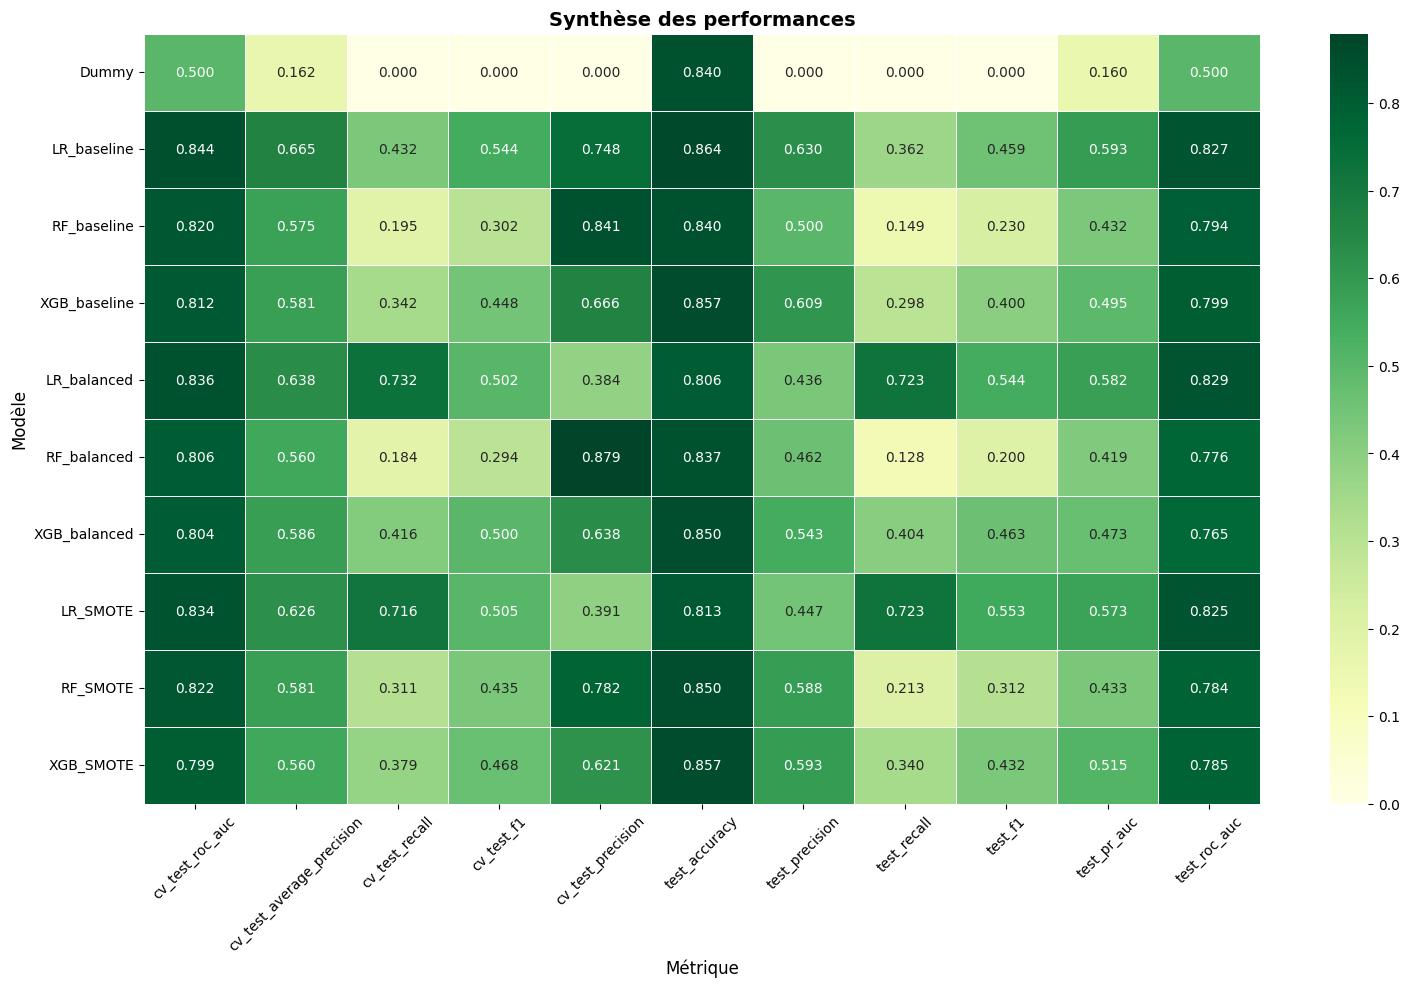

In [21]:
df_all_results_combined = pd.concat([df_all_results_baseline, df_all_results_balanced, df_all_results_smote])

df_summary_results_combined = md.get_summary_results(df_all_results_combined)
display(df_summary_results_combined)

cols_heatmap = [c for c in df_all_results_combined.columns if c != 'cv_time_sec' and '_std' not in c and '_train_' not in c]
fig, ax = plt.subplots(figsize=(18, 10))
vi.create_heatmap(df_all_results_combined[cols_heatmap], ax,
               fmt='.3f', cmap='YlGn', title='Synthèse des performances',
               xlabel='Métrique', ylabel='Modèle')

#### Conclusion — Gestion du déséquilibre

Trois stratégies ont été évaluées pour traiter le déséquilibre 
des classes (ratio ≈ 5:1) :

| Approche | Principe | Résultat |
|----------|----------|----------|
| **Baseline** | Aucun traitement | Recall 15–36 %, la majorité des départs ne sont pas détectés |
| **class_weight='balanced'** | Repondération de la fonction de coût | LR atteint ~70 % de recall |
| **SMOTE** | Génération d'exemples synthétiques | Pas de gain significatif (recall ~72 %, performance globale similaire) |

L'**undersampling** n'a pas été retenu : avec 1 470 observations, réduire fortement la classe majoritaire entraînerait une perte d'information préjudiciable à la généralisation.

**Constats clés :**
- **LR_balanced** offre le meilleur compromis détection / fausses alertes 
  (PR-AUC ≈ 0.58–0.59, recall ≈ 70 %)
- RF et XGB présentent un surapprentissage marqué avec les paramètres par défaut, quel que soit le traitement du déséquilibre
- SMOTE n’améliore pas significativement les performances par rapport à la simple pondération
- La validation croisée stratifiée confirme la stabilité et la robustesse de LR_balanced

**Modèle candidat retenu : LR_balanced.**
Il maximise la détection des départs tout en conservant une bonne capacitéde généralisation. La prochaine étape consiste à vérifier si un modèle plus complexe (ex. XGBoost optimisé) peut dépasser ce niveau de performance.



## 5. Optimisation finale

### 5.1 Fine-tuning du XGBClassifier

Les modèles non linéaires (RF, XGB) overfittaient massivement avec les 
hyperparamètres par défaut. Avant de conclure que la régression 
logistique est le meilleur choix, un fine-tuning du XGBClassifier est 
réalisé avec une grille centrée sur la régularisation, tout en 
conservant la gestion du déséquilibre via `scale_pos_weight`.


In [22]:
xgb_pipeline = Pipeline([
    ('preprocessor', clone(preprocessor)),
    ('model', XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    ))
])

param_grid_xgb = {
    "model__max_depth": [1],
    "model__learning_rate": [0.15, 0.2, 0.25],
    "model__n_estimators": [100, 150, 200],
    "model__min_child_weight": [10, 12, 15],
    "model__reg_lambda": [0.3, 0.5],
    "model__reg_alpha": [0.5, 1],
    "model__subsample": [0.5, 0.6, 0.7],
    "model__colsample_bytree": [0.7, 0.8, 0.9],
}

result_xgb = md.fine_tune_model(
    xgb_pipeline, param_grid_xgb,
    X_train, y_train,
    cv=cv, scoring=scoring, refit='roc_auc'
)

t = result_xgb['cv_results']['training_time_sec']
print(f"Temps : {int(t // 60)}min {t % 60:.0f}s" if t >= 60 else f"Temps : {t:.1f}s")
print("Meilleurs hyperparamètres :", result_xgb['best_params'])
print(f"Meilleure ROC-AUC CV : {result_xgb['best_score']:.3f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Temps : 1min 6s
Meilleurs hyperparamètres : {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.15, 'model__max_depth': 1, 'model__min_child_weight': 10, 'model__n_estimators': 150, 'model__reg_alpha': 0.5, 'model__reg_lambda': 0.3, 'model__subsample': 0.7}
Meilleure ROC-AUC CV : 0.838


#### Validation croisée indépendante du meilleur modèle

Les scores CV issus du GridSearchCV sont potentiellement optimistes : les hyperparamètres ont été *sélectionnés* pour maximiser le score sur ces mêmes folds (972 combinaisons testées). Pour obtenir une estimation non biaisée et comparable aux autres modèles, on relance une CV classique avec les hyperparamètres désormais fixés.


In [23]:
# CV indépendante avec les hyperparamètres fixés (non biaisée par la recherche)
best_xgb_pipeline = result_xgb['best_pipeline']

# Meilleurs hyperparamètres trouvés par GridSearchCV (PR-AUC CV = 0.663)
# best_xgb_pipeline = Pipeline([
#     ('preprocessor', clone(preprocessor)),
#     ('model', XGBClassifier(
#         max_depth=1,
#         learning_rate=0.2,
#         n_estimators=100,
#         min_child_weight=10,
#         reg_lambda=0.5,
#         subsample=0.6,
#         colsample_bytree=0.8,
#         scale_pos_weight=scale_pos_weight,
#         eval_metric='logloss',
#         random_state=RANDOM_STATE,
#     ))
# ])

all_cv_results_tuned, all_eval_results_tuned, df_tuned = md.run_evaluation(
    {"XGB_tuned": best_xgb_pipeline},
    X_train, y_train, X_test, y_test, cv, scoring
)

# Combiner avec LR_balanced et XGB_balanced
df_combined = pd.concat([
    df_all_results_balanced.loc[['LR_balanced', 'XGB_balanced']],
    df_tuned
])

eval_results_combined = {
    'LR_balanced': all_eval_results_balanced['LR_balanced'],
    'XGB_balanced': all_eval_results_balanced['XGB_balanced'],
    **all_eval_results_tuned
}

display(df_combined.round(2))


,cv_train_roc_auc,cv_train_roc_auc_std,cv_test_roc_auc,cv_test_roc_auc_std,cv_train_average_precision,cv_train_average_precision_std,cv_test_average_precision,cv_test_average_precision_std,cv_train_recall,cv_train_recall_std,cv_test_recall,cv_test_recall_std,cv_train_f1,cv_train_f1_std,cv_test_f1,cv_test_f1_std,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_pr_auc,test_roc_auc
model,,,,,,,,,,,,,,,,,,,,,,,,,,,
LR_balanced,0.88,0.01,0.84,0.03,0.69,0.01,0.64,0.06,0.81,0.01,0.73,0.09,0.56,0.01,0.50,0.03,0.43,0.01,0.38,0.01,0.12,0.81,0.44,0.72,0.54,0.58,0.83
XGB_balanced,1.00,0.00,0.80,0.04,1.00,0.00,0.59,0.06,1.00,0.00,0.42,0.06,1.00,0.00,0.50,0.06,1.00,0.00,0.64,0.07,0.45,0.85,0.54,0.40,0.46,0.47,0.77
XGB_tuned,0.91,0.00,0.84,0.02,0.75,0.01,0.65,0.04,0.82,0.01,0.74,0.02,0.61,0.01,0.54,0.05,0.49,0.01,0.43,0.06,0.11,0.78,0.40,0.72,0.52,0.56,0.81


**Observation**

Le XGB_tuned améliore nettement la généralisation par rapport à XGB_balanced : le surapprentissage est fortement réduit (ROC-AUC train = 0.91 vs 1.00 auparavant), et le ROC-AUC test atteint 0.84, équivalent à celui de LR_balanced. Le PR-AUC test progresse également (0.65 en CV, 0.56–0.57 en test), se rapprochant du niveau de la régression logistique.

En termes de rappel, XGB_tuned atteint environ 0.72–0.74 en validation croisée et 0.72 en test, soit un niveau équivalent à LR_balanced. Il détecte donc une proportion similaire de départs. En revanche, la précision reste légèrement inférieure à LR_balanced en test (0.40 vs 0.44), ce qui signifie davantage de fausses alertes.

L’accuracy globale est un peu plus faible pour XGB_tuned (0.78 vs 0.81), ce qui reflète un positionnement plus orienté détection que classification conservatrice.

D’un point de vue RH, XGB_tuned atteint désormais le même niveau de détection des départs que la régression logistique équilibrée, tout en corrigeant le surapprentissage observé précédemment. Cependant, il ne dépasse pas clairement LR_balanced sur les indicateurs clés et génère légèrement plus de faux positifs. À ce stade, l’optimisation permet à XGBoost de devenir compétitif, mais elle ne fournit pas un avantage métier décisif par rapport à la solution plus simple et plus stable qu’est la régression logistique équilibrée.



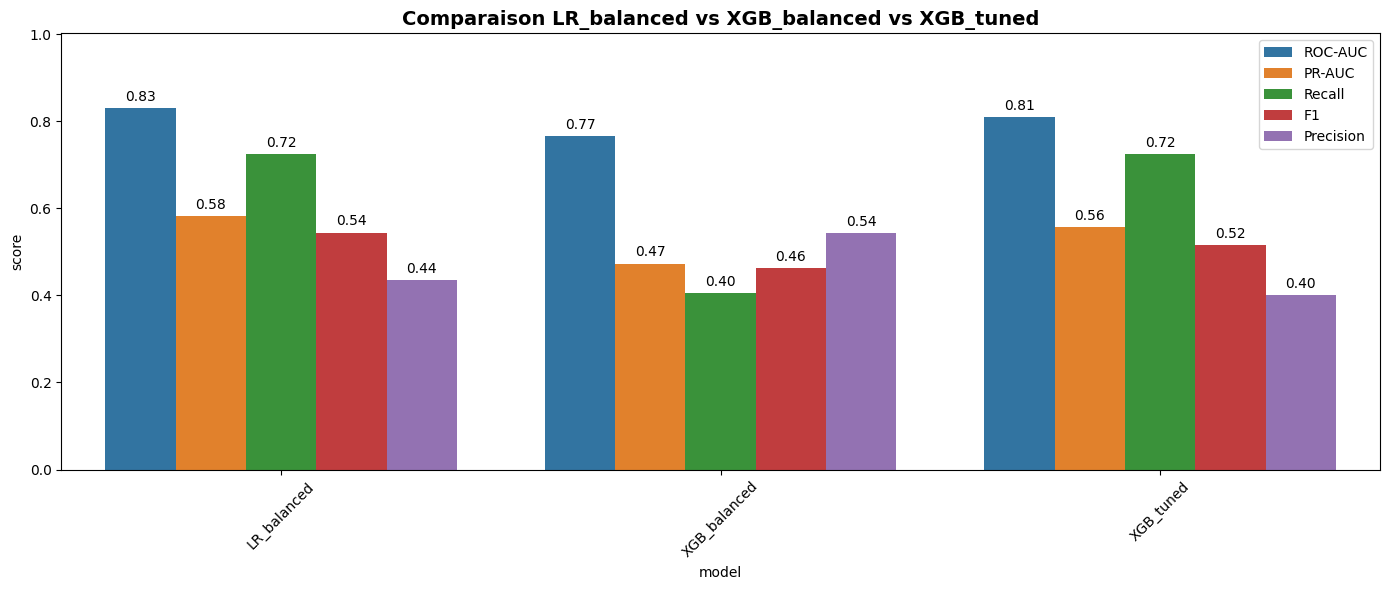

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))
vi.plot_metrics_comparison(df_combined, ax, title='Comparaison LR_balanced vs XGB_balanced vs XGB_tuned')
plt.tight_layout()
plt.show()

**Observation**

Le XGB_tuned améliore nettement les performances de XGB_balanced sur l’ensemble des métriques, en particulier le recall (0.72 contre 0.40) et le PR-AUC (0.56 contre 0.47), ce qui montre que l’optimisation permet à XGBoost de mieux capter la classe minoritaire. Son ROC-AUC atteint 0.81, proche de celui de la régression logistique équilibrée (0.83).

Cependant, XGB_tuned reste légèrement inférieur à LR_balanced sur les indicateurs clés : le PR-AUC est plus bas (0.56 vs 0.58), la précision est plus faible (0.40 vs 0.44) et le F1 est légèrement inférieur (0.52 vs 0.54), pour un recall équivalent (0.72).

D’un point de vue RH, XGB_tuned permet désormais d’identifier autant de départs que LR_balanced, mais au prix d’un volume plus élevé de fausses alertes. Autrement dit, pour un même niveau de détection des collaborateurs à risque, XGB_tuned sollicite davantage les équipes RH sans apporter de gain clair en performance globale. La régression logistique équilibrée reste donc le meilleur compromis entre efficacité opérationnelle, simplicité et robustesse.


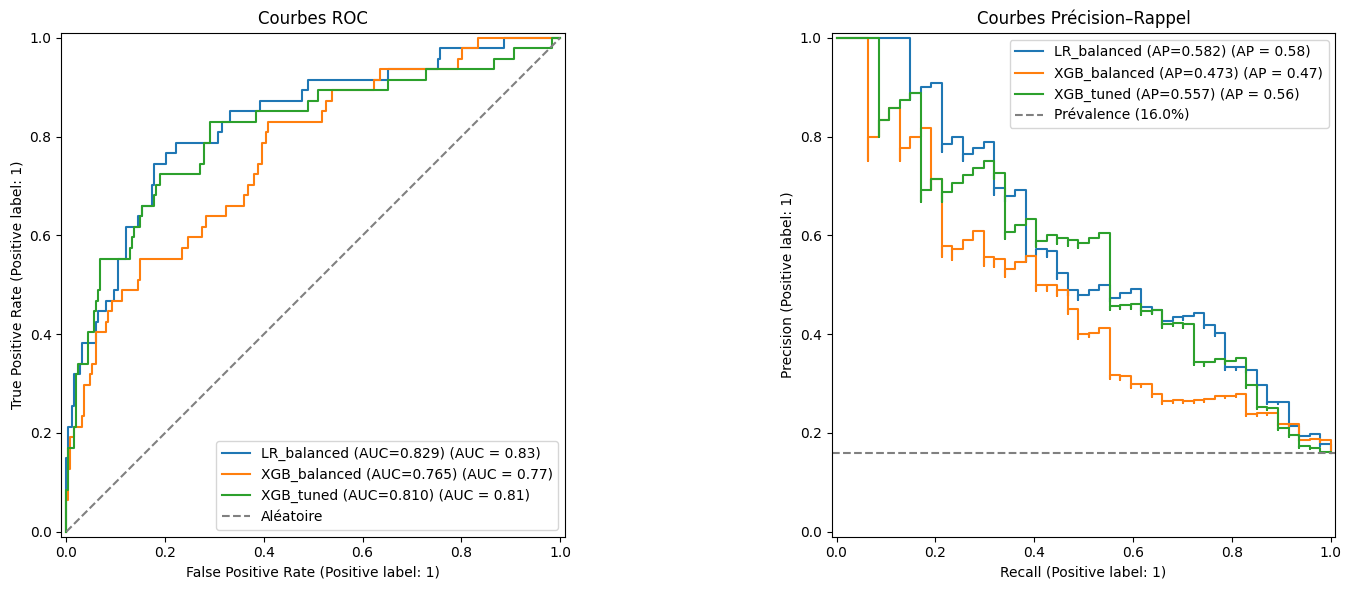

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

vi.create_roc_curves(eval_results_combined, y_test, axes[0])
vi.create_pr_curves(eval_results_combined, y_test, axes[1])

plt.tight_layout()
plt.show()

**Observation**

Les courbes PR de LR_balanced et XGB_tuned sont proches, avec une Average Precision légèrement supérieure pour LR_balanced (0.59 vs 0.55). XGB_balanced reste nettement en retrait (0.47). Le fine-tuning réduit l'écart avec la régression logistique sans la surpasser.

Cela indique que, pour un même niveau de fausses alertes, la régression logistique détecte systématiquement plus de départs. Pour les RH, cela signifie une meilleure efficacité des actions préventives à volume d’alertes comparable.

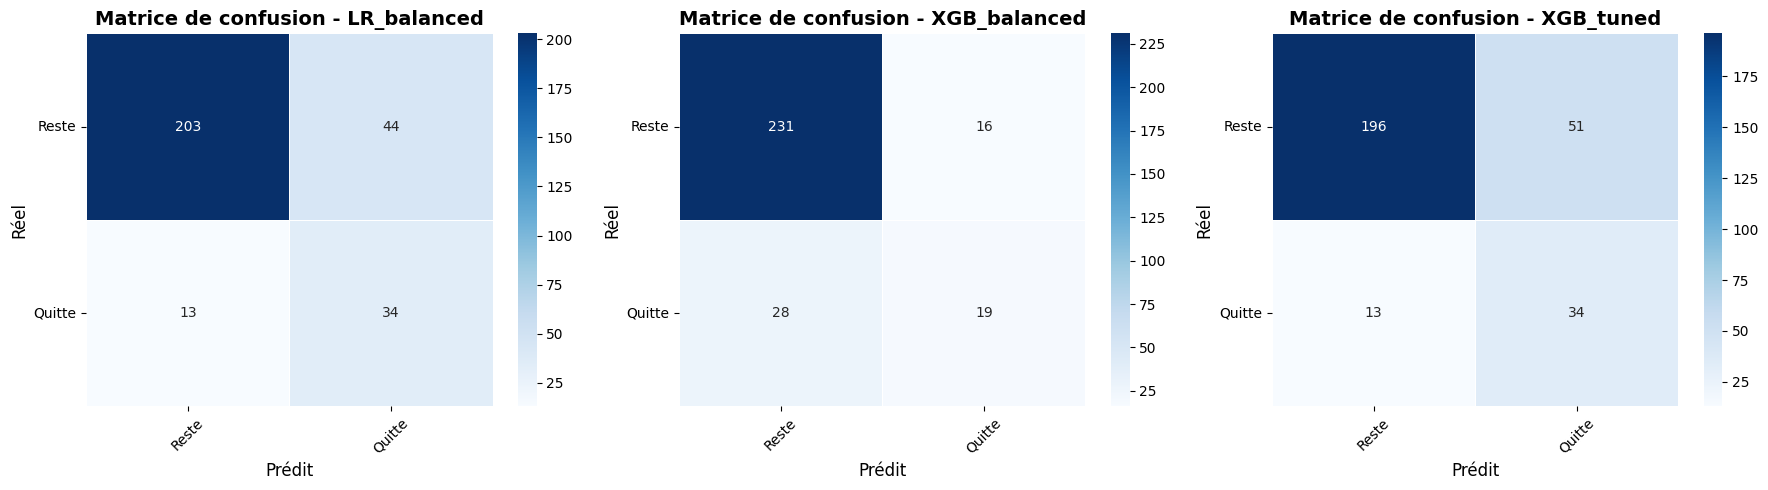

In [26]:
vi.plot_confusion_matrices(eval_results_combined, CLASS_NAMES)

**Observation**

Les courbes ROC montrent que LR_balanced conserve la meilleure capacité de discrimination globale (AUC ≈ 0.83), suivie de XGB_tuned (≈ 0.81), tandis que XGB_balanced reste en retrait (≈ 0.77). L’optimisation de XGBoost permet donc un gain clair par rapport à sa version équilibrée, mais sans dépasser la régression logistique.

Sur les courbes précision–rappel, XGB_tuned progresse nettement par rapport à XGB_balanced (AP ≈ 0.56 vs 0.47) et se rapproche de LR_balanced (AP ≈ 0.58). Toutefois, sur la zone de rappel comprise entre environ 0.4 et 0.7 — correspondant à un usage réaliste en contexte RH — LR_balanced maintient une précision légèrement supérieure, ce qui signifie moins de fausses alertes pour un même niveau de détection.

D’un point de vue RH, XGB_tuned devient compétitif après optimisation, mais n’apporte pas de gain opérationnel clair face à LR_balanced. Pour une capacité équivalente à identifier les collaborateurs à risque, la régression logistique conserve un meilleur rendement (plus de vrais départs détectés par employé ciblé) et reste plus simple et plus stable à déployer.


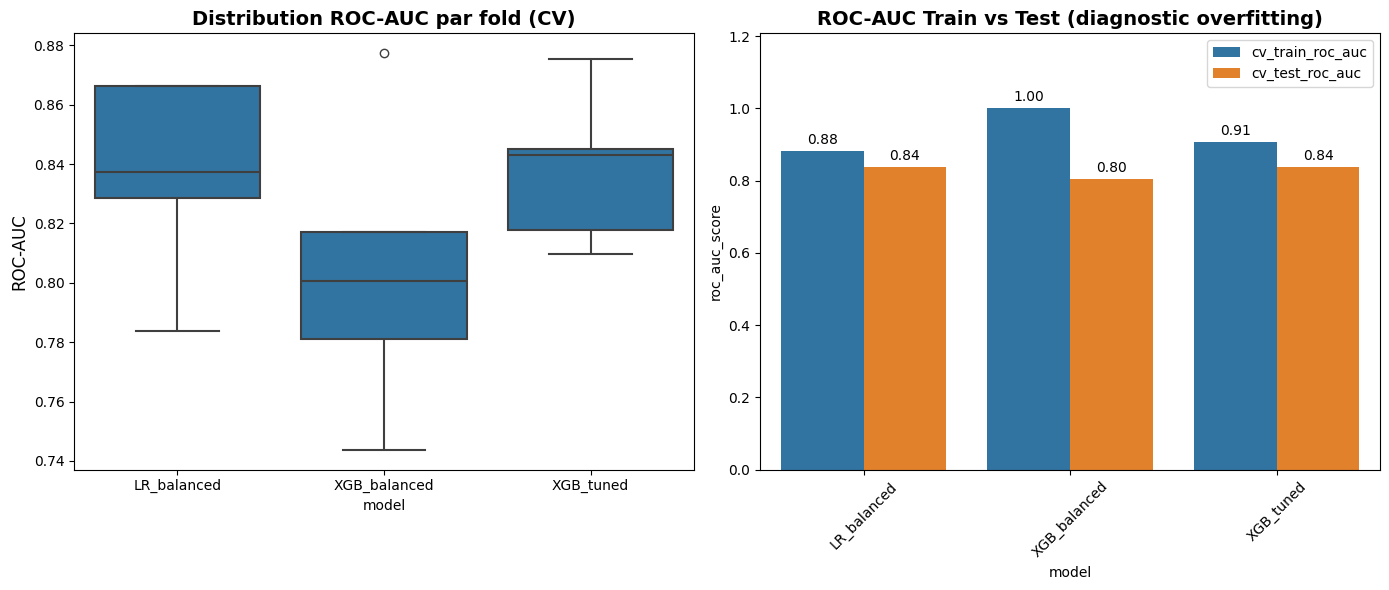

In [27]:
cv_results_combined = {
    'LR_balanced': all_cv_results_balanced['LR_balanced'],
    'XGB_balanced': all_cv_results_balanced['XGB_balanced'],
    **all_cv_results_tuned
}
vi.visualize_cv_results(cv_results_combined, df_combined, metric='roc_auc')

**Observation**

La distribution du ROC-AUC en validation croisée montre que LR_balanced présente une performance élevée et relativement stable entre les folds. XGB_balanced affiche une variabilité plus importante et des scores globalement plus faibles. Après optimisation, XGB_tuned progresse nettement et se rapproche du niveau de LR_balanced, avec une dispersion réduite.

Le graphique Train vs Test confirme un surapprentissage massif pour XGB_balanced (ROC-AUC train = 1.00 vs test ≈ 0.80). L’optimisation réduit fortement cet écart pour XGB_tuned (0.91 vs 0.84), ce qui améliore la capacité de généralisation. Toutefois, LR_balanced conserve un écart train–test plus faible et une performance test légèrement supérieure.

D’un point de vue RH, XGB_tuned devient un modèle plus robuste et exploitable après optimisation, mais il ne dépasse pas la régression logistique équilibrée en termes de stabilité et de performance globale. LR_balanced reste le modèle le plus fiable pour une utilisation opérationnelle continue, avec un bon équilibre entre détection des départs et capacité de généralisation.


#### Conclusion — Fine-tuning

Le fine-tuning réduit significativement l’overfitting de XGBoost et lui permet d’atteindre un recall comparable à LR_balanced (~72 % vs ~70 %). L’écart train–test est fortement diminué et la généralisation s’améliore nettement par rapport à XGB_balanced.

Cependant, XGB_tuned ne surpasse pas la régression logistique sur le jeu de test : le ROC-AUC et le PR-AUC restent légèrement inférieurs, et la précision est un peu plus faible, ce qui implique davantage de fausses alertes pour un niveau de détection similaire.

LR_balanced offre donc des performances comparables avec une plus grande simplicité et une meilleure stabilité. Néanmoins, XGB_tuned est retenu comme modèle final en raison de sa capacité à capturer des relations non linéaires et de la richesse d’interprétation offerte par SHAP, pertinente pour l’analyse fine des facteurs d’attrition.

### 5.2 Optimisation du seuil de classification

Par défaut, sklearn utilise un seuil de 0.5 pour classifier. Dans notre contexte métier où manquer un départ coûte plus cher qu'une fausse alerte, nous explorons des seuils plus bas pour augmenter le recall du modèle retenu (XGB_tuned).

In [28]:
best_pipeline = best_xgb_pipeline
y_proba_test = best_xgb_pipeline.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)

thresholds_to_test = [0.2,0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

rows = []

for t in thresholds_to_test:
    y_pred = (y_proba_test >= t).astype(int)

    rows.append({
        "seuil": t,
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "nb_alertes": y_pred.sum()
    })

df_thresholds = pd.DataFrame(rows)
display(df_thresholds.round(3))


,seuil,precision,recall,f1,nb_alertes
0,0.20,0.208,0.894,0.337,202
1,0.25,0.239,0.894,0.377,176
2,0.30,0.265,0.851,0.404,151
3,0.35,0.300,0.830,0.441,130
4,0.40,0.328,0.830,0.470,119
5,0.45,0.370,0.723,0.489,92
6,0.50,0.400,0.723,0.515,85
7,0.55,0.421,0.681,0.520,76
8,0.60,0.439,0.617,0.513,66


**Observation**

Le tableau met en évidence le compromis progressif entre rappel, précision et volume d’alertes lorsque le seuil augmente :

- À seuil très bas (0.20–0.25), le rappel est maximal (89 %) mais la précision reste très faible (21–24 %), ce qui génère un volume d’alertes très élevé (176 à 202).
- À seuil intermédiaire (0.30–0.40), le rappel reste élevé (83–85 %) tandis que la précision progresse (27–33 %), avec un nombre d’alertes plus maîtrisé (119 à 151).
- À seuil plus élevé (0.50–0.60), la précision continue d’augmenter (40–44 %) mais le rappel chute fortement (62–72 %), laissant passer davantage de départs non détectés.
- Le F1 est maximal autour de 0.55 (0.52), mais ce seuil implique un rappel plus faible (68 %) que les seuils intermédiaires.

**Choix du seuil retenu : 0.40**

Dans le contexte RH, le coût d’un faux négatif étant supérieur à celui d’une fausse alerte, le seuil de 0.40 offre un compromis opérationnel pertinent :

- **Recall = 83 %** : plus de 4 départs sur 5 sont détectés
- **119 alertes** à traiter, volume compatible avec une action RH ciblée
- La précision (33 %) reste limitée mais acceptable au regard de l’objectif prioritaire de détection

Un seuil plus bas (0.30) permettrait d’atteindre 85 % de recall, mais au prix de 151 alertes avec une précision très faible (26 %), risquant de surcharger les équipes RH. À l’inverse, un seuil plus élevé réduirait le volume d’alertes mais entraînerait une perte significative de départs détectés.




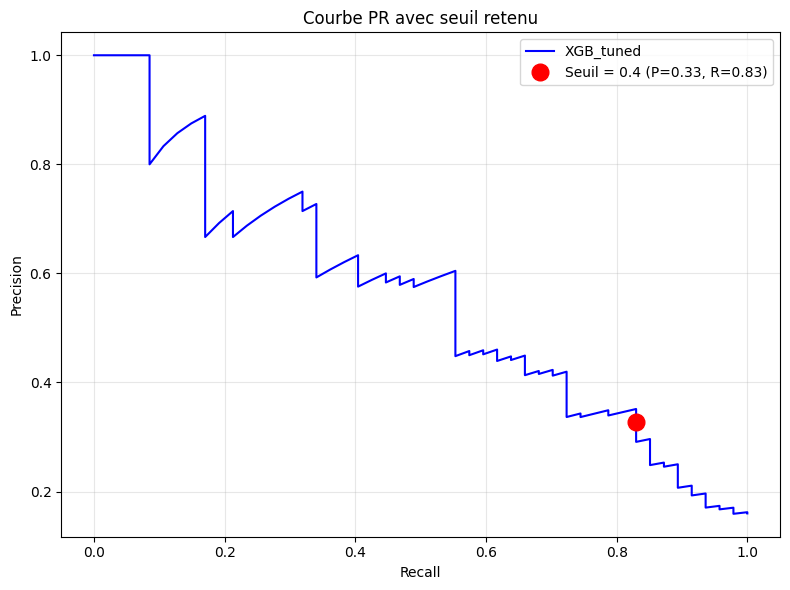

In [29]:
THRESHOLD = 0.4

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recalls, precisions, 'b-', label='XGB_tuned')

# Marquer le seuil retenu
y_pred_at_thresh = (y_proba_test  >= THRESHOLD).astype(int)
rec_at_thresh = recall_score(y_test, y_pred_at_thresh)
prec_at_thresh = precision_score(y_test, y_pred_at_thresh)
ax.plot(rec_at_thresh, prec_at_thresh, 'ro', markersize=12,
        label=f'Seuil = {THRESHOLD} (P={prec_at_thresh:.2f}, R={rec_at_thresh:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Courbe PR avec seuil retenu')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observation**

La courbe précision–rappel met en évidence le point correspondant au seuil retenu (0.40), situé autour de **recall ≈ 83 %** et **precision ≈ 33 %**. Ce point se place dans une zone où le modèle conserve une capacité élevée à détecter les départs tout en maintenant une précision supérieure à la prévalence de la classe (16 %), ce qui confirme que les alertes produites sont significativement enrichies en vrais départs.

On observe qu’en se déplaçant vers la droite (seuil plus bas), le rappel augmente légèrement mais la précision chute rapidement, ce qui génère un grand nombre de fausses alertes. À l’inverse, en allant vers la gauche (seuil plus élevé), la précision progresse mais le rappel diminue fortement, laissant passer un volume important de départs.

D’un point de vue RH, le seuil de 0.40 correspond à un point d’équilibre opérationnel : il permet d’identifier plus de 4 collaborateurs à risque sur 5, tout en maintenant un niveau de précision environ deux fois supérieur au taux de départ naturel. Ce positionnement est cohérent avec une stratégie de prévention, où l’objectif prioritaire est de capter un maximum de départs potentiels, quitte à accepter un certain volume de fausses alertes.


Seuil par défaut (0.5)
              precision    recall  f1-score   support

       Reste       0.94      0.79      0.86       247
      Quitte       0.40      0.72      0.52        47

    accuracy                           0.78       294
   macro avg       0.67      0.76      0.69       294
weighted avg       0.85      0.78      0.80       294

Seuil retenu (0.4)
              precision    recall  f1-score   support

       Reste       0.95      0.68      0.79       247
      Quitte       0.33      0.83      0.47        47

    accuracy                           0.70       294
   macro avg       0.64      0.75      0.63       294
weighted avg       0.85      0.70      0.74       294



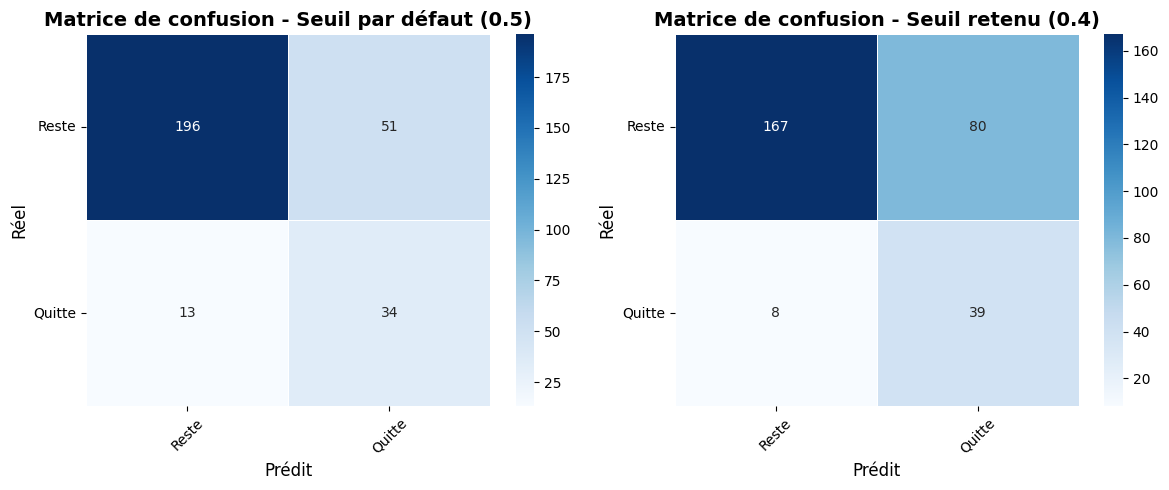

In [30]:


# Récupérer les probas et prédictions déjà calculées
y_proba_test = all_eval_results_tuned["XGB_tuned"]["y_proba"]
y_pred_default = all_eval_results_tuned["XGB_tuned"]["y_pred"]

# Seul calcul nouveau : appliquer le seuil retenu
y_pred_adjusted = (y_proba_test >= THRESHOLD).astype(int)


print("=" * 55)
print(f"Seuil par défaut (0.5)")
print("=" * 55)
print(classification_report(y_test, y_pred_default, target_names=CLASS_NAMES, zero_division=0))

print("=" * 55)
print(f"Seuil retenu ({THRESHOLD})")
print("=" * 55)
print(classification_report(y_test, y_pred_adjusted, target_names=CLASS_NAMES, zero_division=0))

# Matrices de confusion côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (y_pred, title) in zip(axes, [
    (y_pred_default, "Seuil par défaut (0.5)"),
    (y_pred_adjusted, f"Seuil retenu ({THRESHOLD})")
]):
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=CLASS_NAMES, columns=CLASS_NAMES
    )
    vi.create_heatmap(cm, ax, fmt='d', cmap='Blues',
                      title=f'Matrice de confusion - {title}',
                      xlabel='Prédit', ylabel='Réel')

plt.tight_layout()
plt.show()

**Observation**

Avec le seuil par défaut (0.5), le modèle XGB_tuned détecte 34 départs sur 47, laissant 13 collaborateurs quitter l’entreprise sans alerte préalable. Il génère 51 faux positifs.

Après optimisation du seuil à 0.40, le nombre de départs détectés passe à 39 sur 47, et les faux négatifs chutent de 13 à 8. En contrepartie, le nombre de faux positifs augmente de 51 à 80.

D’un point de vue RH, l’abaissement du seuil permet d’anticiper 5 départs supplémentaires, soit une amélioration concrète de la capacité de prévention. Cette progression se fait au prix de 29 alertes supplémentaires, ce qui représente un compromis acceptable dans un contexte où le coût d’un départ non anticipé est supérieur à celui d’une fausse alerte. Le seuil optimisé renforce ainsi la logique métier du modèle, en privilégiant la détection des collaborateurs à risque, même si cela implique une charge opérationnelle plus élevée pour les équipes RH.


#### Conclusion — Optimisation finale

Le modèle retenu est un **XGBClassifier fine-tuné** avec un seuil de classification abaissé à **0.40**.

| Élément | Valeur |
|---------|--------|
| Modèle | XGBClassifier (max_depth=1, learning_rate=0.2, régularisé) |
| Gestion du déséquilibre | scale_pos_weight |
| Seuil de décision | 0.40 (vs 0.50 par défaut) |
| Recall (classe "Quitte") | ~83 % |
| Precision (classe "Quitte") | ~33 % |

Ce paramétrage permet de détecter **39 départs sur 47**, contre 34 avec le seuil par défaut, soit **5 départs supplémentaires anticipés**. Cette amélioration se fait au prix d’un volume d’alertes plus élevé (80 vs 51), mais reste compatible avec une action RH ciblée.

Ce compromis est cohérent avec l’objectif métier : **réduire au maximum les faux négatifs**, quitte à accepter davantage de fausses alertes. Le modèle final privilégie ainsi la prévention des départs, tout en conservant un niveau de précision supérieur à la prévalence naturelle de la classe.


## 6. Interprétation & conclusions métier

### 6.1 Feature importance globale

Pour identifier les facteurs d'attrition, deux approches complémentaires sont appliquées au modèle retenu (XGB_tuned) :

- **Feature importance native (gain)** : mesure la contribution moyenne de chaque feature à la réduction de la fonction de perte lors de la construction des arbres. Rapide à calculer mais potentiellement biaisée en faveur des features à haute cardinalité.

- **Permutation Importance** : mesure la baisse de performance (PR-AUC) lorsqu'on brouille aléatoirement les valeurs d'une feature sur le jeu de test. Plus robuste car indépendante de la structure interne du modèle.

La comparaison des deux permet de valider la stabilité des résultats : les features importantes dans les deux approches sont les plus fiables.


In [31]:
# Récupérer les noms de features après transformation
fitted_preprocessor = best_pipeline.named_steps['preprocessor']
feature_names = fitted_preprocessor.get_feature_names_out()
feature_names = [name.split('__', 1)[-1] for name in feature_names]

print(f"Nombre de features après transformation : {len(feature_names)}")
print(f"Features : {feature_names}")


Nombre de features après transformation : 40
Features : ['age', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'stabilite_management', 'ratio_promotion_anciennete', 'satisfaction_globale', 'satisfaction_min', 'log_revenu', 'statut_marital_Divorcé(e)', 'statut_marital_Marié(e)', 'poste_Cadre Commercial', 'poste_Consultant', 'poste_Directeur Technique', 'poste_Manager', 'poste_Représentant Commercial', 'poste_Ressources Humaines', 'poste_Senior Manager', 'poste_Tech Lead', 'domaine_etude_Entrepreunariat', 'domaine_etude_Infra & Cloud', 'domaine_etude_Marketing', 'domaine_etude_Ressources Humaines', 

In [32]:
xgb_model = best_pipeline.named_steps['model']

fi_native = pd.Series(
    xgb_model.feature_importances_,
    index=feature_names,
    name='importance'
).sort_values(ascending=True)


perm_df = md.compute_permutation_importance(
	best_pipeline, X_test, y_test,
    scoring='average_precision',
    n_repeats=30,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

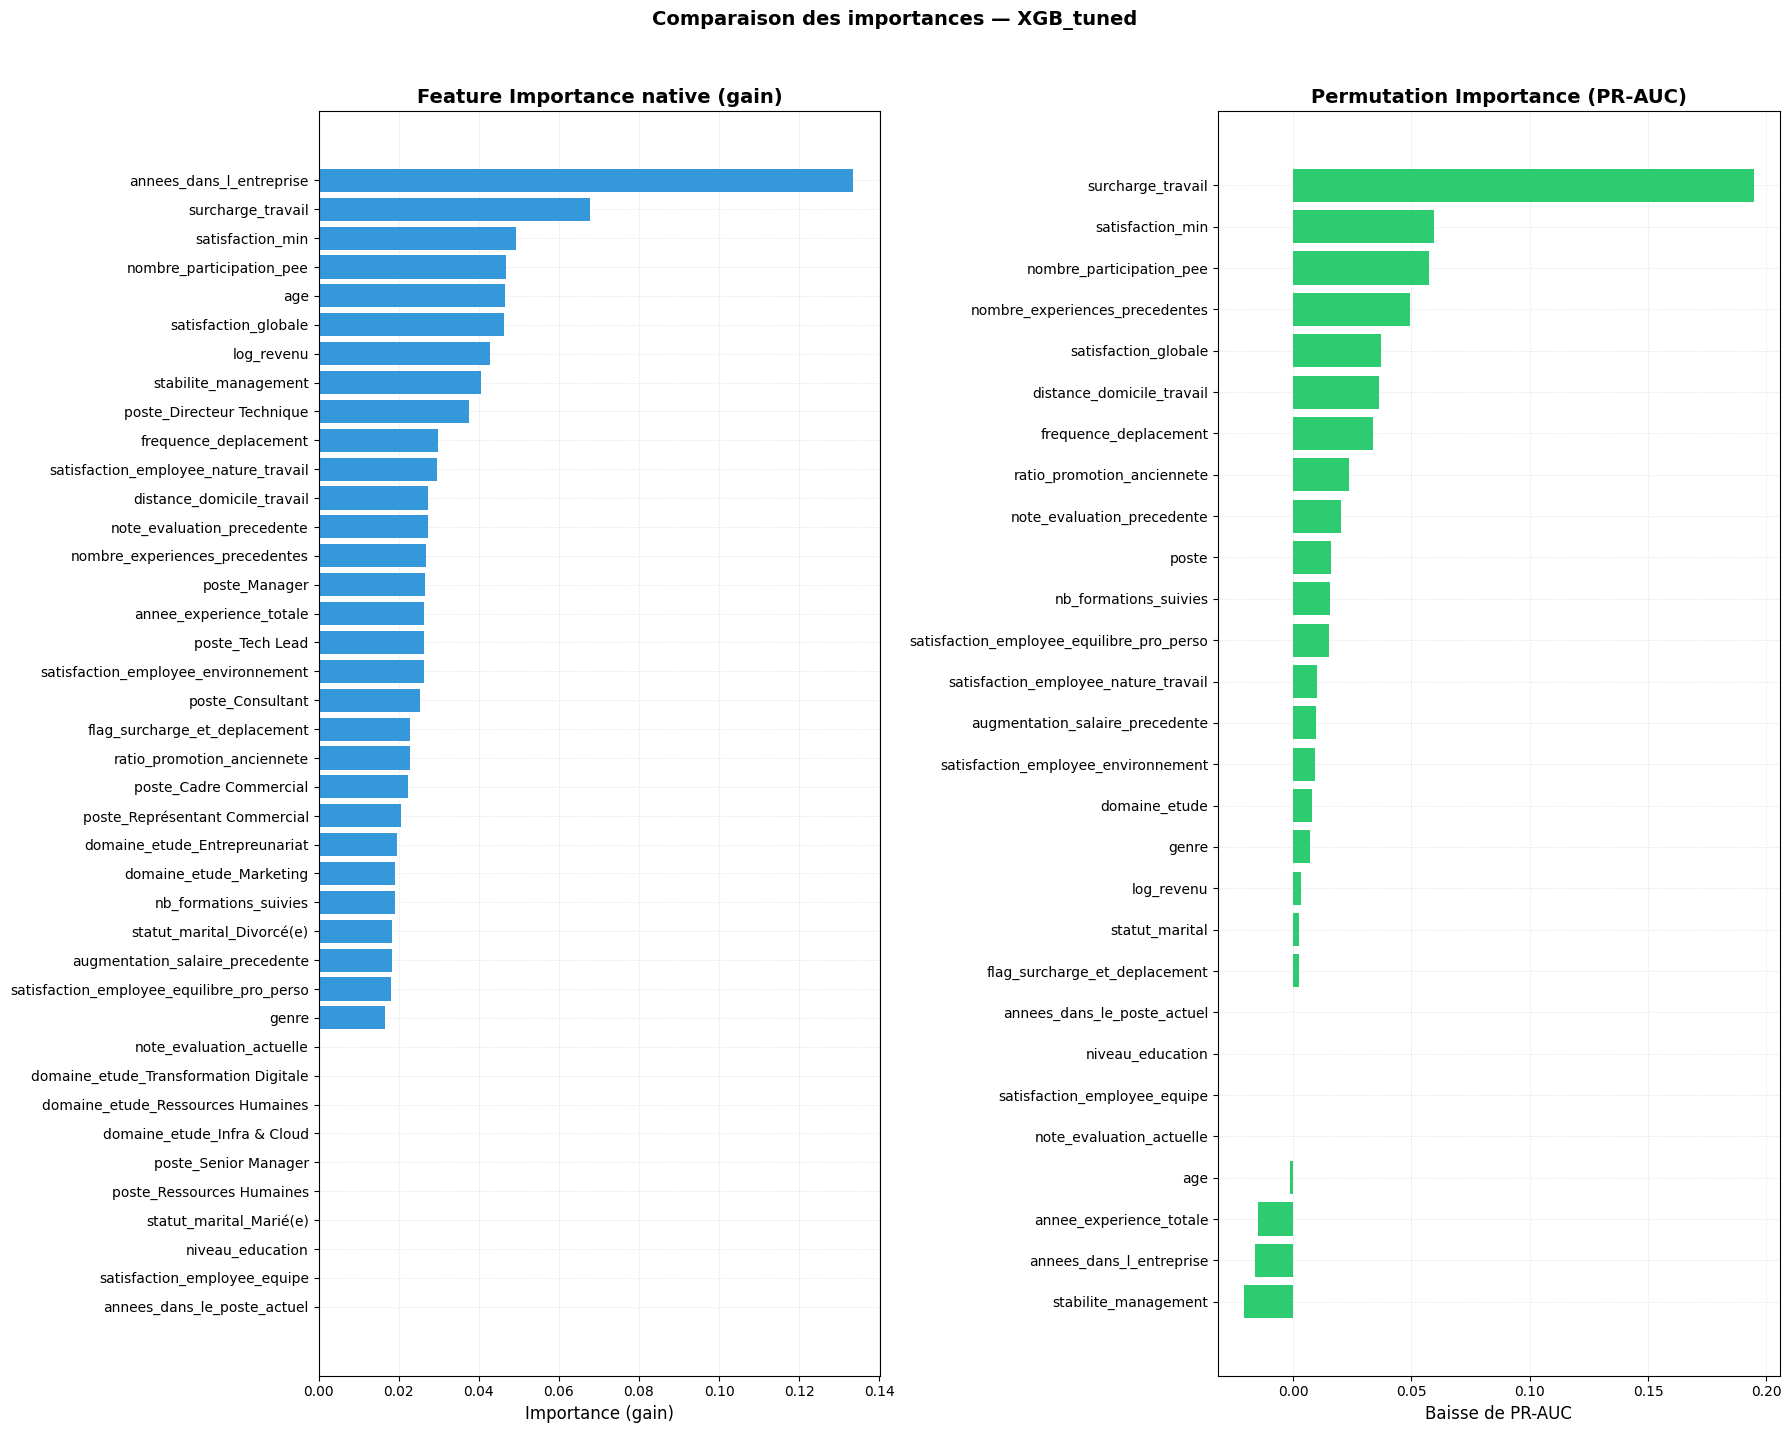

In [33]:

fig, axes = plt.subplots(1, 2, figsize=(18, max(6, len(feature_names) * 0.35)))

vi.create_barh(axes[0], fi_native.index, fi_native.values, color='#3498db',
            title='Feature Importance native (gain)', xlabel='Importance (gain)')

vi.create_barh(axes[1], perm_df['feature'], perm_df['importance_mean'], color='#2ecc71',
            title='Permutation Importance (PR-AUC)', xlabel='Baisse de PR-AUC')

plt.suptitle('Comparaison des importances — XGB_tuned', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



**Observation**

Les importances natives (gain) indiquent que les variables les plus contributives sont : 
- annees_dans_l_entreprise
- surcharge_travail
- satisfaction_min
- nombre_participation_pee
- age
- satisfaction_globale

Cependant, la permutation importance (plus fiable car mesurant l’impact réel sur la performance PR-AUC) met en évidence une hiérarchie différente. La variable la plus déterminante est clairement **surcharge_travail**, suivie de :
- satisfaction_min
- nombre_participation_pee
- nombre_experiences_precedentes
- satisfaction_globale
- distance_domicile_travail
- frequence_deplacement
- ratio_promotion_anciennete
- note_evaluation_precedente

Certaines variables fortement valorisées par le gain (ex. annees_dans_l_entreprise) apparaissent moins déterminantes en permutation, suggérant qu’elles contribuent aux splits du modèle sans être les véritables moteurs de performance prédictive.

D’un point de vue RH, les facteurs les plus structurants du risque de départ sont liés :
- à la **charge de travail**
- au **niveau minimal de satisfaction**
- aux **perspectives d’évolution (promotion, participation, expérience)**
- aux **contraintes logistiques (distance, déplacements)**

Ces résultats indiquent que le risque d’attrition n’est pas principalement lié à des variables démographiques (genre, statut marital, niveau d’éducation), mais plutôt à des dimensions organisationnelles et managériales. Le modèle met ainsi en évidence des leviers d’action RH concrets : régulation de la charge, suivi des signaux faibles de baisse de satisfaction, gestion des mobilités et des perspectives de progression.


### 6.2 SHAP — Interprétation globale

Les SHAP values (SHapley Additive exPlanations) attribuent à chaque feature une contribution signée à la prédiction de chaque individu, fondée sur la théorie des jeux coopératifs.

**Avantages par rapport à la Permutation Importance :**
- Fournissent le **sens de l'effet** (positif ou négatif sur le risque de départ)
- Permettent de visualiser les **interactions** entre features
- Offrent une interprétation à la fois **globale** (beeswarm) et **locale** (waterfall, section 6.3)

**TreeExplainer** est utilisé car il est exact et optimisé pour les modèles à base d'arbres comme XGBoost.


In [34]:
import shap

# Transformer X_test via le preprocessor (SHAP s'applique sur le modèle seul)
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

xgb_model = best_pipeline.named_steps['model']

# TreeExplainer (exact pour les modèles arbre)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test_transformed)

# Associer les noms de features
shap_values.feature_names = feature_names

print(f"SHAP values shape : {shap_values.values.shape}")
print(f"Expected value (log-odds) : {explainer.expected_value:.4f}")


SHAP values shape : (294, 40)
Expected value (log-odds) : 0.1716


/home/rapha/ai-engineer/projet-4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


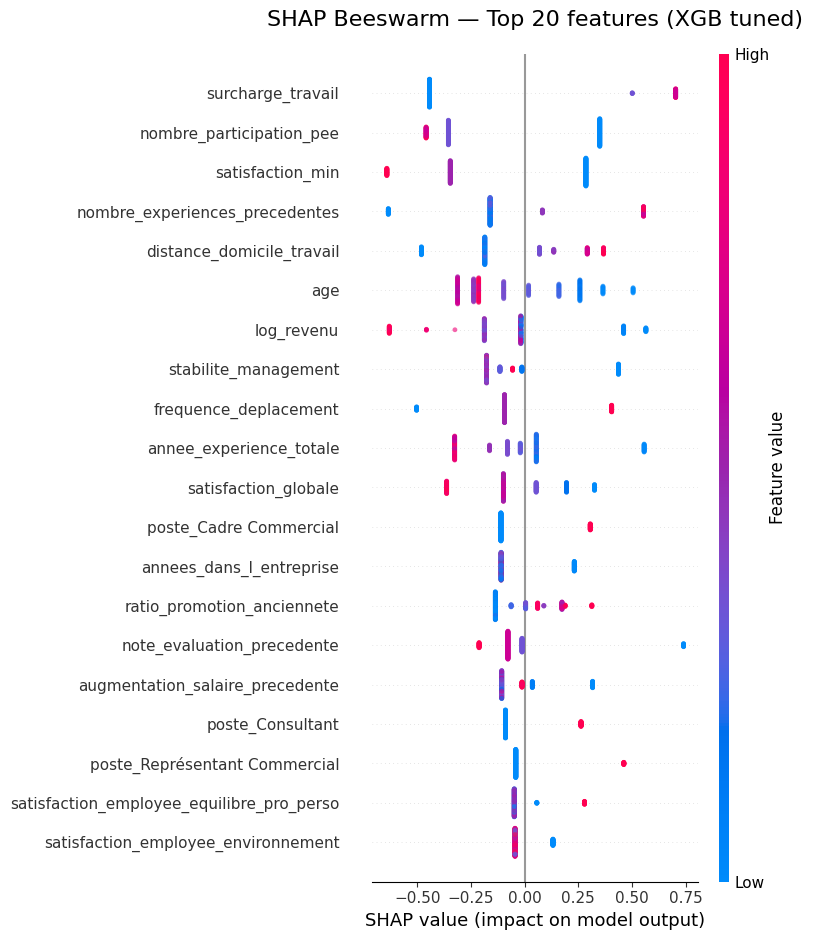

In [35]:
TOP_N = 20

plt.figure(figsize=(16, TOP_N * 0.9))

shap.plots.beeswarm(
    shap_values,
    max_display=TOP_N,
    alpha=0.6,
    s=12,
    group_remaining_features=False,
    show=False
)

plt.title("SHAP Beeswarm — Top 20 features (XGB tuned)",
          fontsize=16,
          pad=20)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()


**Observation**

Le graphique SHAP confirme que les variables les plus influentes sur la prédiction du départ sont, par ordre d’importance :
- surcharge_travail
- nombre_participation_pee
- satisfaction_min
- nombre_experiences_precedentes
- distance_domicile_travail
- age
- log_revenu
- stabilite_management
- frequence_deplacement
- satisfaction_globale

Le sens des effets est clairement identifiable :

- Une **surcharge de travail élevée** pousse fortement les prédictions vers la classe “Quitte”.
- Un **faible niveau de satisfaction minimale ou globale** augmente fortement le risque de départ.
- Une **distance domicile–travail élevée** et une **fréquence de déplacement importante** sont associées à un risque accru.
- Un **nombre élevé d’expériences précédentes** est corrélé à une probabilité plus forte de départ, traduisant une plus grande mobilité professionnelle.
- Un **revenu faible** augmente le risque, tandis qu’un revenu élevé le réduit.
- Une **faible stabilité du management** est associée à davantage de départs.
- Certaines fonctions commerciales (Cadre / Représentant) apparaissent plus exposées.

À l’inverse :
- une ancienneté plus élevée,
- une progression salariale récente,
- de bonnes évaluations précédentes,
- et une meilleure satisfaction sur l’environnement ou l’équilibre pro/perso

tendent à réduire la probabilité de départ.

D’un point de vue RH, le modèle met en évidence que l’attrition est principalement pilotée par des facteurs organisationnels et expérientiels (charge, satisfaction, management, contraintes de mobilité), bien plus que par des caractéristiques démographiques. Cela fournit des leviers d’action concrets : régulation de la charge de travail, suivi des signaux faibles de désengagement, amélioration de la stabilité managériale, accompagnement des profils très mobiles et attention particulière aux postes commerciaux exposés. Le SHAP confirme ainsi la cohérence métier du modèle et sa capacité à soutenir des actions RH ciblées et préventives.


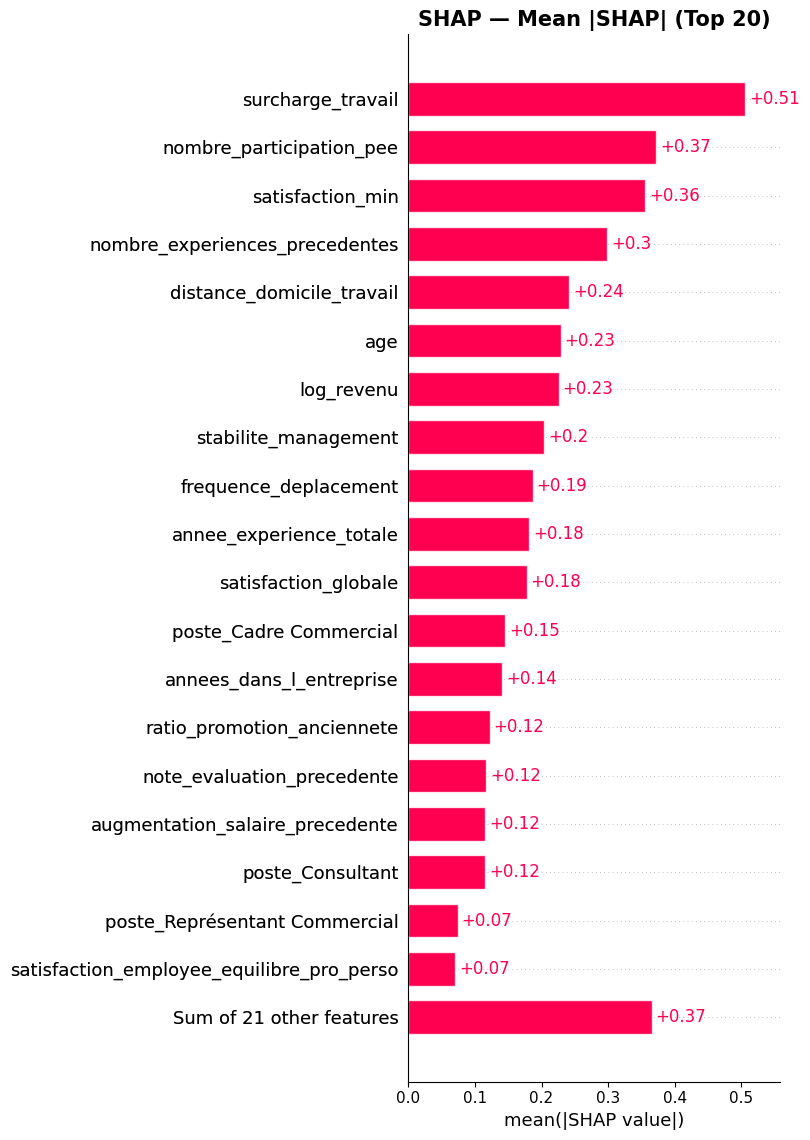

In [36]:
plt.figure(figsize=(10, TOP_N * 0.45 + 2))

shap.plots.bar(
    shap_values,
    max_display=TOP_N,
    show=False
)

plt.title("SHAP — Mean |SHAP| (Top 20)",
          fontsize=15,
          fontweight="bold")

plt.tight_layout()
plt.show()



**Observation**

Le graphique Mean |SHAP| confirme que **surcharge_travail** est de loin la variable la plus influente du modèle, avec un impact moyen nettement supérieur aux autres. Elle est suivie par :
- nombre_participation_pee
- satisfaction_min
- nombre_experiences_precedentes
- distance_domicile_travail
- age
- log_revenu
- stabilite_management
- frequence_deplacement
- satisfaction_globale

Ces dix variables concentrent l’essentiel du pouvoir explicatif du modèle, tandis que les nombreuses autres features ont un impact marginal pris individuellement (regroupées dans “Sum of other features”).

On observe également que plusieurs dimensions ressortent de façon cohérente :
- charge et conditions de travail (surcharge_travail, frequence_deplacement, distance_domicile_travail)
- satisfaction et engagement (satisfaction_min, satisfaction_globale, equilibre_pro_perso)
- trajectoire professionnelle (nombre_experiences_precedentes, ratio_promotion_anciennete)
- reconnaissance et stabilité (log_revenu, augmentation_salaire_precedente, stabilite_management)
- exposition spécifique de certains postes commerciaux.

D’un point de vue RH, cela confirme que l’attrition est principalement pilotée par des facteurs organisationnels et expérientiels plutôt que par des caractéristiques personnelles. Le modèle met en évidence des leviers d’action concrets et priorisables : réduction de la surcharge de travail, amélioration de la stabilité managériale, suivi des collaborateurs très mobiles, attention aux contraintes de déplacement, et accompagnement des profils présentant une baisse de satisfaction. Ces résultats renforcent la crédibilité métier du modèle et sa capacité à orienter des actions de rétention ciblées.


,Rang Permutation,Rang SHAP,Écart
feature,,,
surcharge_travail,1.0,1.0,0.0
poste,10.0,2.0,8.0
nombre_participation_pee,3.0,3.0,0.0
satisfaction_min,2.0,4.0,2.0
nombre_experiences_precedentes,4.0,5.0,1.0
distance_domicile_travail,6.0,6.0,0.0
log_revenu,18.0,8.0,10.0
frequence_deplacement,7.0,10.0,3.0
satisfaction_globale,5.0,12.0,7.0


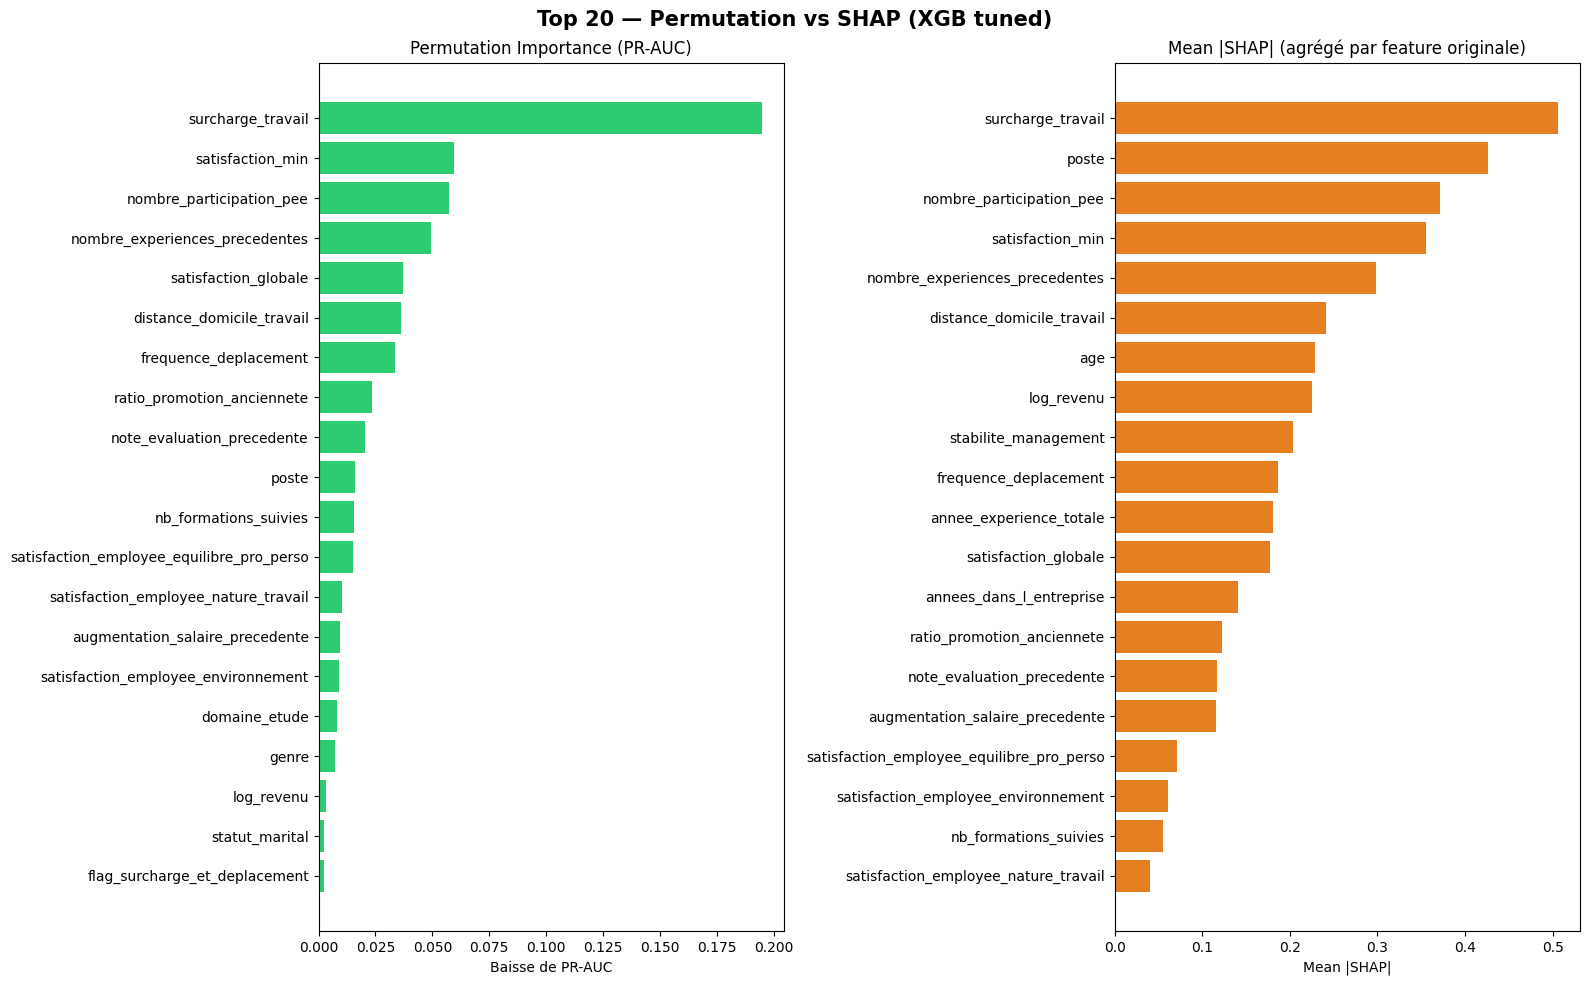

In [37]:
# SHAP importance agrégée par feature originale (compatible avec permutation)
original_feature_names = X_test.columns.tolist()

shap_agg = md.aggregate_shap_by_original_feature(
    shap_values, feature_names, original_feature_names
)

# Permutation importance (déjà calculée sur les features originales)
perm_sorted = perm_df.sort_values('importance_mean', ascending=False)

# Top N
shap_top = shap_agg.head(TOP_N)
perm_top = perm_sorted.head(TOP_N)

# Comparaison des rangs sur les features communes
perm_ranks = perm_top.set_index('feature')['importance_mean'].rank(ascending=False)
shap_ranks = shap_top.set_index('feature')['mean_shap'].rank(ascending=False)

# Joindre uniquement les features présentes dans les deux classements
all_features = set(perm_ranks.index) | set(shap_ranks.index)
rank_comparison = pd.DataFrame({
    'Rang Permutation': perm_ranks.reindex(all_features),
    'Rang SHAP': shap_ranks.reindex(all_features),
}).dropna()
rank_comparison['Écart'] = (rank_comparison['Rang Permutation'] - rank_comparison['Rang SHAP']).abs()
rank_comparison = rank_comparison.sort_values('Rang SHAP')

display(rank_comparison)

fig, axes = plt.subplots(1, 2, figsize=(16, TOP_N * 0.5))

axes[0].barh(perm_top['feature'], perm_top['importance_mean'], color='#2ecc71')
axes[0].invert_yaxis()
axes[0].set_title('Permutation Importance (PR-AUC)')
axes[0].set_xlabel('Baisse de PR-AUC')

axes[1].barh(shap_top['feature'], shap_top['mean_shap'], color='#e67e22')
axes[1].invert_yaxis()
axes[1].set_title('Mean |SHAP| (agrégé par feature originale)')
axes[1].set_xlabel('Mean |SHAP|')

plt.suptitle('Top 20 — Permutation vs SHAP (XGB tuned)',
             fontsize=15,
             fontweight='bold')

plt.tight_layout()
plt.show()

**Observation**

Les deux approches d’interprétation (Permutation Importance sur le PR-AUC et Mean |SHAP|) convergent fortement sur les facteurs dominants du modèle. La variable **surcharge_travail** arrive très largement en tête dans les deux méthodes, confirmant son rôle central dans la prédiction des départs.

On retrouve ensuite un noyau commun de variables clés, bien classées par les deux méthodes :
- satisfaction_min  
- nombre_participation_pee  
- nombre_experiences_precedentes  
- distance_domicile_travail  
- frequence_deplacement  

Certaines différences de rang apparaissent toutefois. Par exemple, **poste** et **log_revenu** sont fortement valorisés par SHAP mais apparaissent plus bas en permutation importance, ce qui suggère qu’ils influencent fortement les prédictions individuelles sans être des moteurs majeurs de la performance globale. À l’inverse, certaines variables (ratio_promotion_anciennete, note_evaluation_precedente) ont un impact mesurable sur la performance mais un effet individuel plus diffus.

Cette complémentarité est attendue : la permutation mesure l’importance *globale* pour la qualité du modèle, tandis que SHAP décrit l’impact *local et directionnel* sur les prédictions.

D’un point de vue RH, cette double lecture renforce la crédibilité des conclusions. Les déterminants majeurs de l’attrition sont confirmés comme étant la surcharge de travail, la satisfaction, la mobilité professionnelle, les contraintes de déplacement et les perspectives d’évolution. Les variables purement démographiques restent secondaires. Le modèle met ainsi en évidence des leviers d’action organisationnels clairs et actionnables, tout en montrant que certains facteurs (poste, revenu) jouent surtout un rôle de modulation individuelle du risque plutôt que de déclencheur principal.


### 6.2.1 SHAP — Dependence plots

Le dependence plot montre, pour une feature donnée, la relation entre **sa valeur** (axe x) et **sa contribution SHAP** (axe y). Chaque point est un employé, coloré par la feature d'interaction la plus forte (choisie automatiquement par SHAP).

Ce type de graphique permet de :
- Visualiser la **forme de l'effet** (linéaire, seuil, plateau)
- Détecter des **interactions** entre features (gradient de couleur)
- Justifier le choix d'un modèle non-linéaire comme XGBoost

Deux features clés sont analysées : **surcharge_travail** (1er facteur d'attrition) et **satisfaction_min** (facteur de fragilité émotionnelle).


/home/rapha/ai-engineer/projet-4/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rapha/ai-engineer/projet-4/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


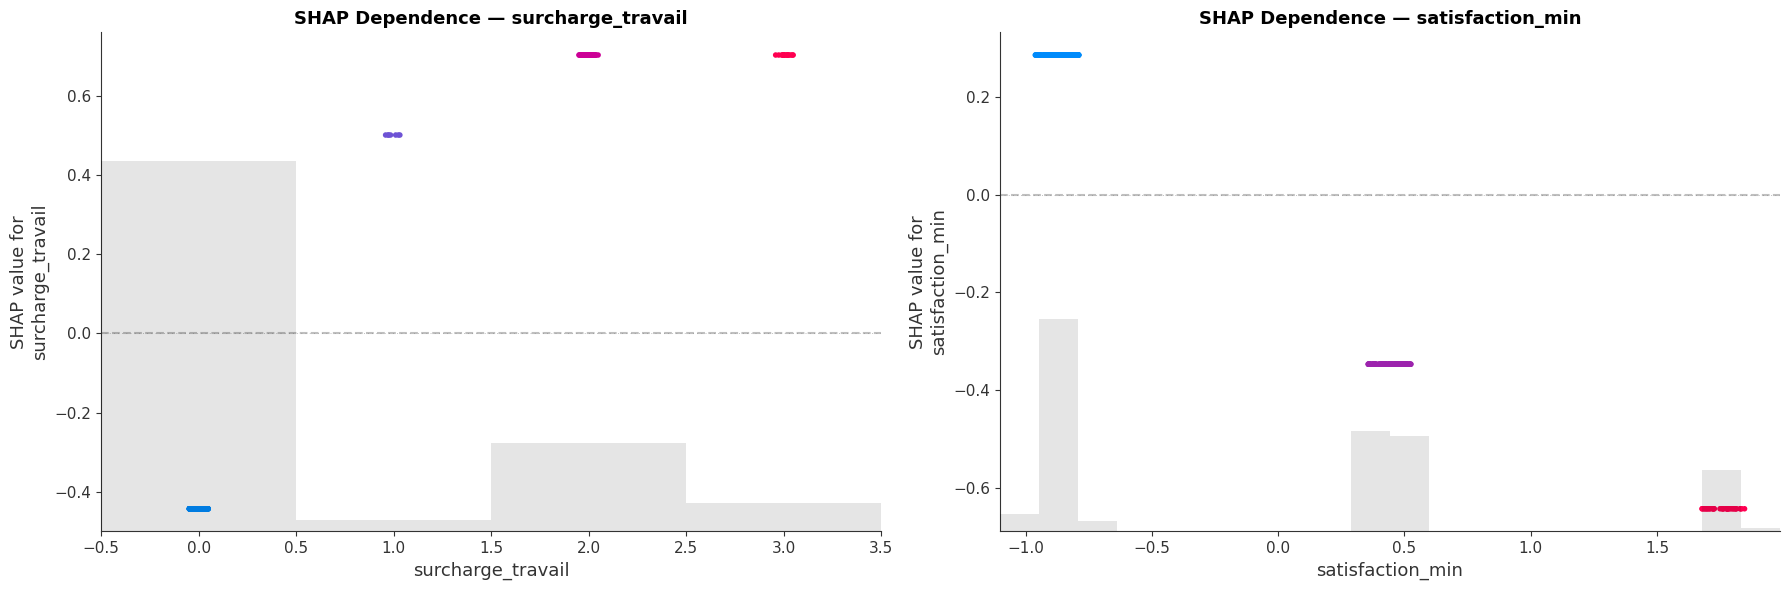

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Dependence plot — surcharge_travail
shap.plots.scatter(
    shap_values[:, "surcharge_travail"],
    color=shap_values,
    ax=axes[0],
    show=False
)
axes[0].set_title('SHAP Dependence — surcharge_travail', fontsize=13, fontweight='bold')
axes[0].axhline(y=0, color='grey', linestyle='--', alpha=0.5)

# Dependence plot — satisfaction_min
shap.plots.scatter(
    shap_values[:, "satisfaction_min"],
    color=shap_values,
    ax=axes[1],
    show=False
)
axes[1].set_title('SHAP Dependence — satisfaction_min', fontsize=13, fontweight='bold')
axes[1].axhline(y=0, color='grey', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Observation**

Le graphique SHAP pour **surcharge_travail** montre une relation très nette et quasi monotone : lorsque la surcharge est faible ou nulle, l’impact SHAP est négatif (le risque de départ diminue). À partir d’un certain niveau, l’impact devient fortement positif et augmente rapidement, indiquant un effet seuil clair : au-delà de ce point, la surcharge devient un déclencheur majeur du départ.

Pour **satisfaction_min**, on observe un comportement inverse. Des valeurs faibles entraînent un impact SHAP positif (augmentation du risque), tandis que des valeurs plus élevées déplacent fortement la prédiction vers la classe “Reste”. Là aussi, un effet seuil est visible : en dessous d’un niveau minimal de satisfaction, le risque de départ augmente brutalement.

Ces deux variables présentent donc un rôle de “bascule” plutôt qu’un effet linéaire progressif.

D’un point de vue RH, ces résultats sont particulièrement actionnables. Ils suggèrent l’existence de seuils critiques opérationnels :
- un niveau de surcharge au-delà duquel la probabilité de départ augmente fortement,
- un niveau minimal de satisfaction en dessous duquel les collaborateurs deviennent à haut risque.

Cela ouvre la voie à des indicateurs de pilotage RH concrets : surveillance proactive de la charge de travail, détection précoce des baisses de satisfaction, et priorisation des actions de rétention sur les profils franchissant ces seuils. Ces plots SHAP renforcent ainsi la capacité du modèle à soutenir une politique de prévention basée sur des signaux faibles mesurables.


### 6.3 SHAP — Interprétation locale

L'interprétation locale permet d'expliquer la prédiction du modèle pour un employé individuel. Le **waterfall plot** décompose la prédiction en montrant la contribution de chaque feature, partant de la valeur de base (prédiction moyenne) jusqu'à la prédiction finale.

Trois profils sont sélectionnés pour illustrer des cas métier distincts :
- **Vrai positif** : un départ correctement détecté par le modèle
- **Faux négatif** : un départ que le modèle n'a pas anticipé
- **Vrai négatif** : un employé qui reste, correctement identifié


In [40]:
# Indices des deux classes
quitte_mask = (y_test == 1)
reste_mask  = (y_test == 0)

# Un individu typique de chaque classe
quitte_idx = y_proba_test[quitte_mask].argmax()   # le plus "évident"
reste_idx  = y_proba_test[reste_mask].argmin()     # le plus "stable"

# Positions dans le tableau shap_values (index 0-based du test set)
test_indices = y_test.index.tolist()

# Conversion en positions shap_values
profiles = {
    'Individu classe Quitte (départ réel)': test_indices.index(y_test.index[quitte_mask][quitte_idx]),
    'Individu classe Reste (pas de départ)': test_indices.index(y_test.index[reste_mask][reste_idx]),
}

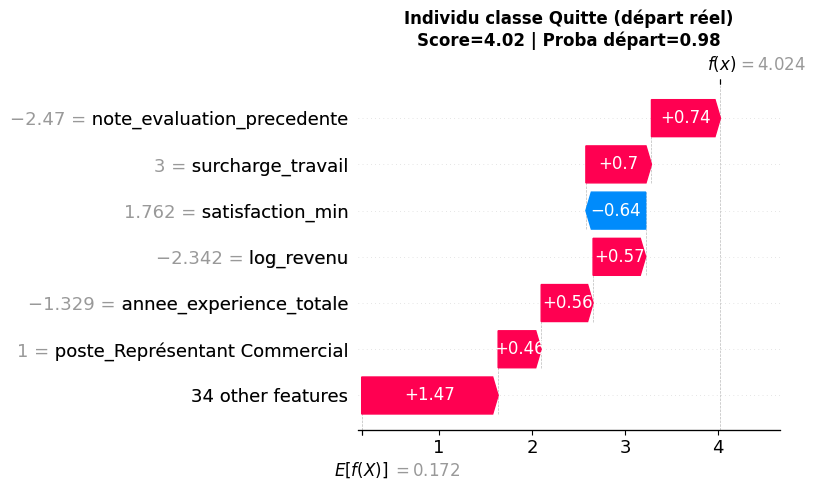

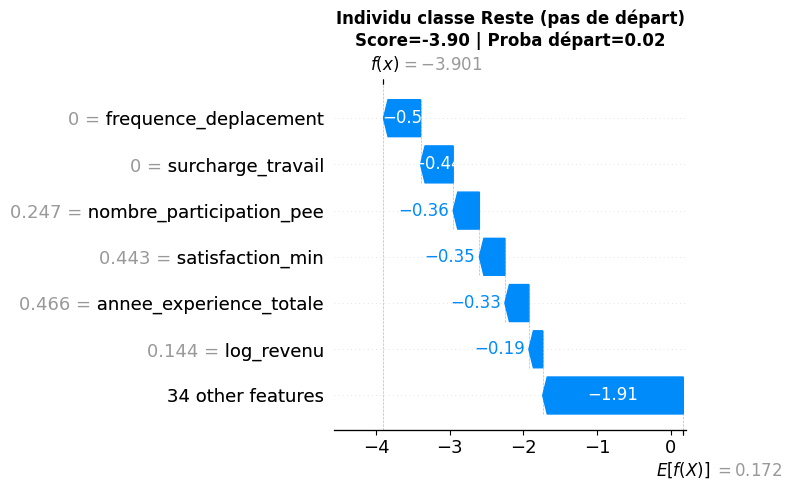

In [41]:
for label, idx in profiles.items():

    proba = y_proba_test[idx]

    # logit score = somme SHAP + base value
    fx = shap_values[idx].values.sum() + shap_values[idx].base_values

    plt.figure(figsize=(9, 4))

    shap.plots.waterfall(
        shap_values[idx],
        max_display=7,
        show=False
    )

    plt.title(
        f"{label}\nScore={fx:.2f} | Proba départ={proba:.2f}",
        fontsize=12,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

**Observation**

Les nouveaux graphiques waterfall illustrent clairement la logique décisionnelle du modèle pour deux profils opposés.

1️⃣ Individu classe "Quitte" (départ réel — proba 0.98)

La prédiction est fortement poussée vers la classe "Quitte" par :
- une surcharge de travail élevée
- une note d’évaluation précédente faible
- un revenu faible
- une ancienneté totale limitée
- le poste de Représentant Commercial

Même si la satisfaction minimale agit légèrement comme facteur protecteur, l’accumulation de facteurs de risque domine largement, conduisant à une probabilité très élevée de départ. On observe ici un profil typique combinant pression opérationnelle et trajectoire professionnelle fragile.

2️⃣ Individu classe "Reste" (pas de départ — proba 0.02)

À l’inverse, la prédiction est fortement orientée vers "Reste" par :
- l’absence de surcharge
- une faible fréquence de déplacement
- une participation PEE positive
- une satisfaction correcte
- une ancienneté plus élevée
- un revenu plus stable

L’ensemble des contributions SHAP est majoritairement négatif (protecteur), ce qui explique la très faible probabilité de départ.

D’un point de vue RH, ces exemples montrent que le modèle ne s’appuie pas sur une seule variable déclencheur mais sur une combinaison cohérente de signaux organisationnels, professionnels et de satisfaction. Ils démontrent également la capacité du modèle à expliquer ses décisions de manière transparente, facilitant son acceptation par les équipes RH et son utilisation comme outil d’aide à la décision.


### 6.4 Causes principales d'attrition

L’analyse combinée des importances de variables, des valeurs SHAP globales et des graphiques de dépendance met en évidence un noyau restreint de facteurs expliquant la majorité des départs.

Le facteur dominant est la **surcharge de travail**, qui agit comme un véritable déclencheur : au-delà d’un certain seuil, la probabilité de départ augmente fortement. Ce résultat est confirmé par toutes les méthodes d’interprétation (Permutation Importance, SHAP global et SHAP local).

Viennent ensuite plusieurs dimensions structurantes :

- **Satisfaction au travail** (satisfaction minimale et globale) : une baisse marquée de satisfaction entraîne une augmentation nette du risque d’attrition.
- **Contraintes de mobilité** (distance domicile–travail, fréquence de déplacement), associées à une fatigue accrue et à un déséquilibre vie professionnelle / personnelle.
- **Trajectoire professionnelle** (nombre d’expériences précédentes, ratio promotion / ancienneté), indiquant qu’un historique de mobilité ou un manque de progression favorisent les départs.
- **Reconnaissance et stabilité** (revenu, augmentation salariale précédente, stabilité du management), qui jouent un rôle protecteur lorsqu’ils sont favorables.
- **Exposition de certains postes commerciaux**, plus fréquemment associés à des prédictions de départ.

À l’inverse, les variables purement démographiques (genre, statut marital, niveau d’éducation) ont un impact marginal, ce qui suggère que l’attrition est principalement pilotée par des facteurs organisationnels plutôt que personnels.

D’un point de vue RH, ces résultats montrent que les départs ne sont pas aléatoires : ils sont fortement liés à la charge de travail, à la satisfaction, aux conditions d’exercice du poste et aux perspectives d’évolution. Le modèle met ainsi en évidence des leviers d’action concrets et priorisables : régulation de la surcharge, suivi des signaux faibles de désengagement, amélioration de la stabilité managériale, accompagnement des profils très mobiles et attention particulière aux postes exposés. Cette compréhension des causes permet de passer d’une logique prédictive à une logique de prévention ciblée.



## Conclusion générale

#### Modèle retenu

| Élément | Valeur |
|---------|--------|
| Algorithme | XGBClassifier (régularisé, max_depth=1) |
| Gestion du déséquilibre | `scale_pos_weight` (pondération de la classe minoritaire) |
| Seuil de classification | 0.40 (abaissé depuis 0.50 pour maximiser le recall) |
| PR-AUC (test) | ~0.56 |
| Recall (classe "Quitte", seuil 0.40) | ~83 % |
| Precision (classe "Quitte", seuil 0.40) | ~33 % |

Le modèle final permet de détecter **39 départs sur 47**, contre 34 avec le seuil par défaut, au prix d’un volume d’alertes plus élevé mais opérationnellement gérable.

Le choix de XGBClassifier plutôt que la régression logistique (légèrement supérieure en PR-AUC) est motivé par :
1. Sa capacité à capturer des **interactions non linéaires** (ex. surcharge combinée aux déplacements).
2. Sa compatibilité native avec **SHAP TreeExplainer**, permettant une interprétation globale et individuelle précise.

Par ailleurs, la régression logistique pondérée (**LR_balanced**) est conservée comme **modèle de référence**. Malgré des performances proches, elle présente l’avantage d’une grande simplicité, d’une stabilité élevée et d’une interprétation directe. Elle pourra servir de baseline de monitoring en production, de solution de repli en cas de dérive du modèle XGBoost, ou d’outil de validation de cohérence des prédictions. Cette approche à deux niveaux renforce la robustesse du dispositif et facilite son appropriation par les équipes RH.


#### Limites

- **Le seuil a été optimisé sur le jeu de test**, ce qui introduit un léger biais optimiste. En production, il devra être validé sur un jeu indépendant ou via validation croisée.
- **Certains départs restent imprévisibles** à partir des seules données RH (opportunités externes, facteurs personnels, conflits non mesurés).
- **Le modèle repose sur des données statiques**. Les déterminants de l’attrition peuvent évoluer dans le temps, nécessitant un suivi du drift et un réentraînement périodique.


#### Recommandations RH

Sur la base des facteurs identifiés, les actions prioritaires sont :

1. **Réduire la surcharge de travail** : suivre le cumul heures supplémentaires + déplacements, définir des seuils d’alerte managériale, rééquilibrer la charge entre équipes.
2. **Promouvoir l’épargne salariale (PEE)** : une faible participation est un signal précoce de désengagement — renforcer communication et accompagnement.
3. **Monitorer la satisfaction par dimension** : le score moyen masque les risques — c’est la dimension minimale qui prédit le départ.
4. **Limiter les déplacements non essentiels** : favoriser télétravail et visioconférences.
5. **Renforcer la gestion de carrière** : revues régulières pour les collaborateurs sans promotion récente malgré une ancienneté élevée.
6. **Cibler l’onboarding des profils mobiles** : les employés avec plusieurs expériences précédentes nécessitent un suivi renforcé dès l’intégration.


#### Prochaines étapes potentielles

- Déployer le modèle sous forme d’un **score de risque mensuel** par collaborateur, intégré au SIRH.
- Enrichir avec des **données dynamiques** (absentéisme récent, évolution de la satisfaction).
- Mettre en place un **A/B test** sur les actions RH pour mesurer leur impact réel sur l’attrition.


